


# Does PySINDy performance vary with the level of chaos, the level of syntactic complexity, or how multi-scale the system is?

This notebook investigates a large database of chaotic systems of pure polynomial expression and polynomial degree <= 4, in order to see if the performance of PySINDy varies with the level of chaos (as measured by the largest Lyapunov exponent) or the level of syntactic complexity.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets
import time

from utils import *

# Annoyingly requires the neurokit2 package - "pip install neurokit2"
from dysts.analysis import sample_initial_conditions

import pysindy as ps

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Seed the random number generators for reproducibility
np.random.seed(100)

# Chaotic System Initialization

This experiment include 77 chaotic systems provided by the database from William Gilpin. "Chaos as an interpretable benchmark for forecasting and data-driven modelling" Advances in Neural Information Processing Systems (NeurIPS) 2021 https://arxiv.org/abs/2110.05266.

In [2]:
t1 = time.time()

# experimental system list
#["AtmosphericRegime"]
systems_list = ["Aizawa", "Arneodo", "Bouali2", 
                "GenesioTesi", "HyperBao", "HyperCai", "HyperJha", 
                "HyperLorenz", "HyperLu", "HyperPang", "Laser",
                "Lorenz", 
                "LorenzBounded", 
                "MooreSpiegel", "Rossler", "ShimizuMorioka",
                # Added a bunch of additional polynomial systems
                "HenonHeiles", "GuckenheimerHolmes", "Halvorsen", "KawczynskiStrizhak",
                "VallisElNino", "RabinovichFabrikant", "NoseHoover", "Dadras", "RikitakeDynamo",
                "NuclearQuadrupole", "PehlivanWei", "SprottTorus", "SprottJerk", "SprottA", "SprottB",
                "SprottC", "SprottD", "SprottE", "SprottF", "SprottG", "SprottH", "SprottI", "SprottJ",
                "SprottK", "SprottL", "SprottM", "SprottN", "SprottO", "SprottP", "SprottQ", "SprottR",
                "SprottS", "Rucklidge", "Sakarya", "RayleighBenard", "Finance", "LuChenCheng",
                "LuChen", "QiChen", "ZhouChen", "BurkeShaw", "Chen", "ChenLee", "WangSun", "DequanLi",
                "NewtonLiepnik", "HyperRossler", "HyperQi", "Qi", "LorenzStenflo", "HyperYangChen", 
                "HyperYan", "HyperXu", "HyperWang", "AtmosphericRegime", "Hadley", "HindmarshRose",
               ]
alphabetical_sort = np.argsort(systems_list)
systems_list = np.array(systems_list)[alphabetical_sort]


# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "embedding_dimension",
    "parameters"
]

# Get training and testing trajectories for all the experimental systems and their attributes
n = 5000
all_sols_train = dict()
all_sols_test = dict()
all_t_train = dict()
all_t_test = dict()
all_properties = dict()

for i, equation_name in enumerate(systems_list):
    eq = getattr(flows, equation_name)()
    print(i, eq)
    try:
        if equation_name == 'AtmosphericRegime':  # or equation_name == 'Hindmarsh Rose':
            resample = False
        else:
            resample = True
        ic_train, ic_test = sample_initial_conditions(eq, 2, traj_length=1000, pts_per_period=30)
        eq.ic = ic_train
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=resample, return_times=True, standardize=False)
        all_sols_train[equation_name] = sol
        all_t_train[equation_name] = t_sol
        eq.ic = ic_test
        t_sol, sol = eq.make_trajectory(n, method="Radau", resample=resample, return_times=True, standardize=False)
        all_sols_test[equation_name] = sol
        all_t_test[equation_name] = t_sol
        attr_vals = [getattr(eq, item, None) for item in attributes]
        all_properties[equation_name] = dict(zip(attributes, attr_vals))
    except SystemError:
        print('Could not load one of the systems: ', equation_name)
    except TypeError:
        print('Could not load one of the systems ', equation_name)
        
t2 = time.time()
print('Took ', t2 - t1, ' seconds to load the systems')

0 Aizawa(name='Aizawa', params={'a': 0.95, 'b': 0.7, 'c': 0.6, 'd': 3.5, 'e': 0.25, 'f': 0.1}, random_state=None)
1 Arneodo(name='Arneodo', params={'a': -5.5, 'b': 4.5, 'c': 1.0, 'd': -1.0}, random_state=None)
2 AtmosphericRegime(name='AtmosphericRegime', params={'alpha': -2.0, 'beta': -5.0, 'mu1': 0.05, 'mu2': -0.01, 'omega': 3.0, 'sigma': 1.1}, random_state=None)
3 Bouali2(name='Bouali2', params={'a': 3.0, 'b': 2.2, 'bb': 0, 'c': 0, 'g': 1.0, 'm': -0.0026667, 'y0': 1.0}, random_state=None)
4 BurkeShaw(name='BurkeShaw', params={'e': 13, 'n': 10}, random_state=None)
5 Chen(name='Chen', params={'a': 35, 'b': 3, 'c': 28}, random_state=None)
6 ChenLee(name='ChenLee', params={'a': 5, 'b': -10, 'c': -0.38}, random_state=None)
7 Dadras(name='Dadras', params={'c': 2.0, 'e': 9.0, 'o': 2.7, 'p': 3.0, 'r': 1.7}, random_state=None)
8 DequanLi(name='DequanLi', params={'a': 40, 'c': 1.833, 'd': 0.16, 'eps': 0.65, 'f': 20, 'k': 55}, random_state=None)
9 Finance(name='Finance', params={'a': 0.001, 'b

In [3]:
num_attractors = len(systems_list)

lyap_list = []
dimension_list = []
param_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])
    dimension_list.append(all_properties[system]['embedding_dimension'])
    param_list.append(all_properties[system]['parameters'])

true_coefficients = make_dysts_true_coefficients(systems_list, 
                                                 all_sols_train, 
                                                 dimension_list, 
                                                 param_list)
true_coefficients[np.where(systems_list=='HindmarshRose')[0][0]]

Aizawa ['      xdot = x * z - b * x - d * y', '        ydot = d * x + y * z - b * y', '        zdot = c + a * z - 0.333333333333333333 * z ** 3 - x ** 2 - y ** 2 - e * z * x ** 2 - e * z * y ** 2 + f * z * x ** 3']
Arneodo ['      xdot = y', '        ydot = z', '        zdot = -a * x - b * y - c * z + d * x ** 3']
AtmosphericRegime ['      xdot = mu1 * x + sigma * x * y', '        ydot = mu2 * y + omega * z + alpha * y * z + beta * z ** 2 - sigma * x ** 2', '        zdot = mu2 * z - omega * y - alpha * y ** 2 - beta * y * z']
Bouali2 ['      xdot = a * y0 * x - a * x * y - b * z', '        ydot = -g * y + g * y * x ** 2', '        zdot = -1.5 * m * x + m * bb * x * z - c * z']
BurkeShaw ['      xdot = -n * x - n * y', '        ydot = y - n * x * z', '        zdot = n * x * y + e']
Chen ['      xdot = a * y - a * x', '        ydot = (c - a) * x - x * z + c * y', '        zdot = x * y - b * z']
ChenLee ['      xdot = a * x - y * z', '        ydot = b * y + x * z', '        zdot = c * z +

SprottJerk ['      xdot = y', '        ydot = z', '        zdot = -x + y ** 2 - mu * z']
SprottK ['      xdot = x * y - z', '        ydot = x - y', '        zdot = x + a * z']
SprottL ['      xdot = y + b * z', '        ydot = a * x ** 2 - y', '        zdot = 1 - x']
SprottM ['      xdot = -z', '        ydot = -x ** 2 - y', '        zdot = a + a * x + y']
SprottN ['      xdot = -2 * y', '        ydot = x + z ** 2', '        zdot = 1 + y - 2 * z']
SprottO ['      xdot = y', '        ydot = x - z', '        zdot = x + x * z + a * y']
SprottP ['      xdot = a * y + z', '        ydot = -x + y ** 2', '        zdot = x + y']
SprottQ ['      xdot = -z', '        ydot = x - y', '        zdot = a * x + y ** 2 + b * z']
SprottR ['      xdot = a - y', '        ydot = b + z', '        zdot = x * y - z']
SprottS ['      xdot = -x - 4 * y', '        ydot = x + z ** 2', '        zdot = 1 + x']
SprottTorus ['      xdot = y + 2 * x * y + x * z', '        ydot = 1 - 2 * x ** 2 + y * z', '        zdot = 

array([[  0.        ,  -1.        ,  33.33333333,  33.33333333,
         33.33333333,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        , -16.33333333,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   1.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,  -0.49      ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0

## Trajectory Visualization

Took  9.106549978256226  seconds to plot the systems


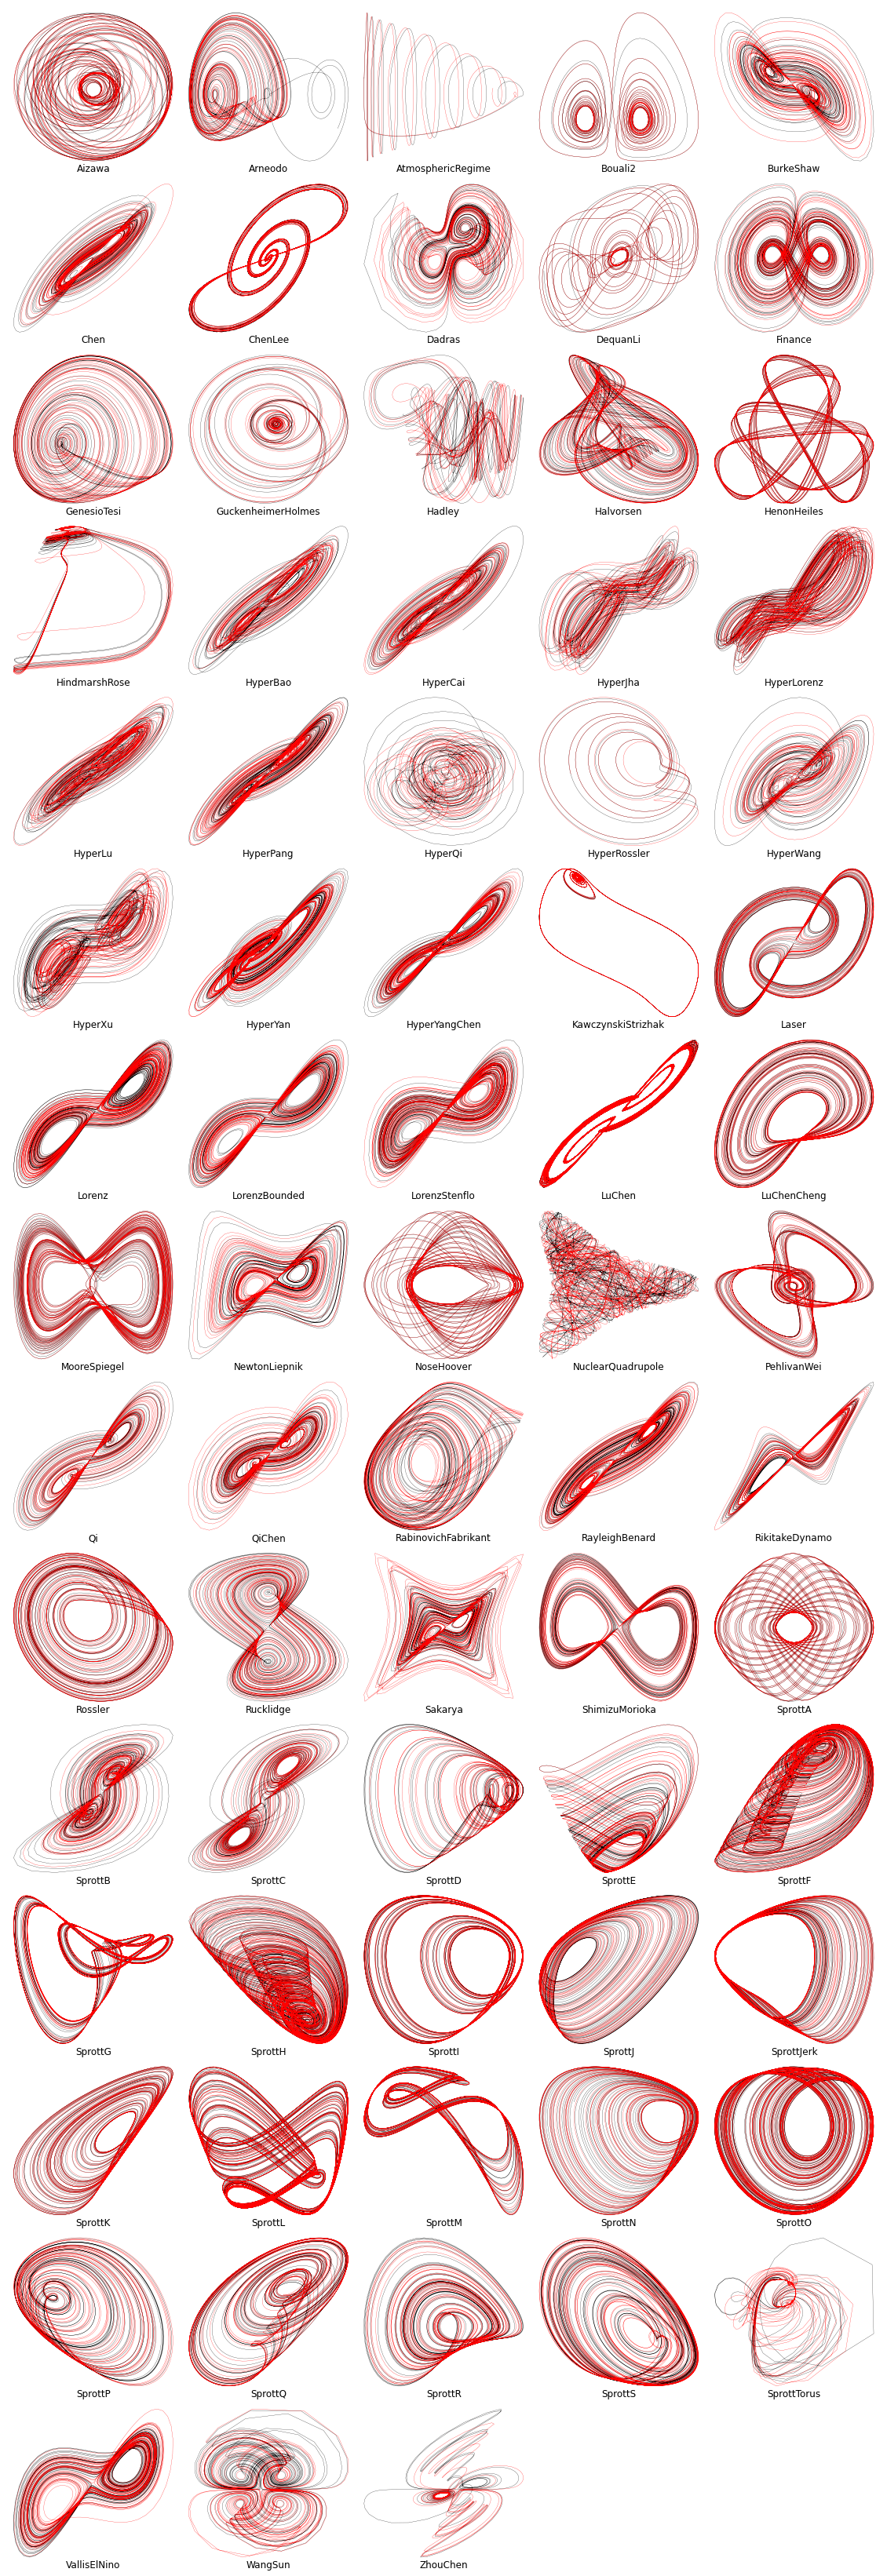

In [4]:
t1 = time.time()

# Plot the training and testing trajectories for all the chaotic systems
num_cols = 5
num_rows = int(np.ceil(len(all_sols_train) / num_cols))
fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.05) 

for i, attractor_name in enumerate(all_sols_train):
    
    x_train = all_sols_train[attractor_name]
    x_test = all_sols_test[attractor_name]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    plt.subplot(gs[i])
    plt.plot(x_train[:, 0], x_train[:, 1], 'k'
             , linewidth=0.25)
    plt.plot(x_test[:, 0], x_test[:, 1], 'r', linewidth=0.25)
    plt.title(attractor_name, y=-0.05)
    plt.gca().axis('off')
            
    
plt.savefig('polynomial_attractors.jpg')
plt.savefig('polynomial_attractors.pdf')
t2 = time.time()
print('Took ', t2 - t1, ' seconds to plot the systems')

In [5]:
# l0_pen = 1e-3, 80 iterations: 
# Bad fits only for: Atmospheric oscillator, Hindmarsh Rose, Kawc..., Qi, QiChen
# -- these might need to be sampled differently because of big transient... ?
# Resampling = False fixes Atmospheric, Hindmarsh just has a weird fit 
# (although needed a fix of the true coefficient array)

## Compute RMSEs and Normalized Errors

In [6]:
t1 = time.time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

# define data structure for records
xdot_rmse_errors = {}
xdot_coef_errors = {}
predicted_coefficients = {}
best_threshold_values = {}

# initialize sturctures
for system in systems_list:
    xdot_rmse_errors[system] = list()
    xdot_coef_errors[system] = list()
    predicted_coefficients[system] = list()
    best_threshold_values[system] = list()
    
# iterate over all systems and noise levels
max_iter = 100
tol_iter = 100
poly_library = ps.PolynomialLibrary(degree=4)
models = []
x_dot_tests = []
x_dot_test_preds = []
num_fits = 1
num_error_levels = 1
error_levels = np.linspace(0.0, 0.0, num_error_levels)

for i, attractor_name in enumerate(systems_list):
    print(i, " / ", num_attractors, ", System = ", attractor_name)

    
    x_train = all_sols_train[attractor_name]
    x_test = all_sols_test[attractor_name]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    if dimension_list[i] == 3:
        input_names = ['x', 'y', 'z']
    else:
        input_names = ['x', 'y', 'z', 'w']
    feature_names = poly_library.fit(x_train).get_feature_names(input_names)
    
    # noise variance controller
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
    
    for error in error_levels:
        
        rmse_errors = np.zeros(num_fits)
        coef_errors = np.zeros((dimension_list[i], len(feature_names), num_fits))
        best_coefs = np.zeros((dimension_list[i], len(feature_names), num_fits))
        best_thresholds = np.zeros(num_fits)
        for j in range(num_fits):
            # construct noisy data
            x_train_noisy = x_train + np.random.normal(0, rmse * error, x_train.shape)

            # rudy train
            coef_best, err_best, coef_history, err_history, threshold_best, model = rudy_algorithm3(
                x_train_noisy, x_test, t_train, 
                ode_lib=poly_library, dtol=1e-4,
                optimizer_max_iter=max_iter,
                tol_iter=tol_iter,
                change_factor=1.2,
                l0_pen=1e-5,
                alpha=1e-5,
                normalize_columns=True,
                t_test=t_test,
                input_names=input_names,
                coef_true=true_coefficients[i]
            )

            x_dot_test = model.differentiate(x_test, t=t_test)
            x_dot_test_pred = model.predict(x_test)
            rmse_errors[j] = normalized_RMSE(x_dot_test, x_dot_test_pred)
            coef_errors[:, :, j] = coefficient_errors(true_coefficients[i], coef_best)
            models.append(model)
            x_dot_tests.append(x_dot_test)
            x_dot_test_preds.append(x_dot_test_pred)
            best_coefs[:, :, j] = coef_best
            best_thresholds[j] = threshold_best

        best_threshold_values[attractor_name].append(np.mean(best_thresholds))
        xdot_rmse_errors[attractor_name].append(np.mean(rmse_errors))
        xdot_coef_errors[attractor_name].append(np.mean(coef_errors, -1))
        predicted_coefficients[attractor_name].append(np.mean(best_coefs, -1))
            
t2 = time.time()
print('Total time to compute = ', t2 - t1, ' seconds')


0  /  73 , System =  Aizawa
0 0.0001 0.0001 0.0027611294150312223 0.0027611294150312223
1 0.00012 0.00012 0.0027611294150312223 0.0027510221565381675
2 0.00024 0.00012 0.0027510221565381675 0.0027510221565381675
3 0.00024 0.000144 0.0027510221565381675 0.0027510221565381675
4 0.00024 0.0001728 0.0027510221565381675 0.0027510221565381675
5 0.00024 0.00020736 0.0027510221565381675 0.0027510221565381675
6 0.000248832 0.000248832 0.0027510221565381675 0.0027510221565381675
7 0.0002985984 0.0002985984 0.0027510221565381675 0.0027510221565381675
8 0.00035831808 0.00035831808 0.0027510221565381675 0.0027510221565381675
9 0.000429981696 0.000429981696 0.0027510221565381675 0.0027410933245305413
10 0.000859963392 0.000429981696 0.0027410933245305413 0.0027410933245305413
11 0.000859963392 0.0005159780352 0.0027410933245305413 0.0027410933245305413
12 0.000859963392 0.00061917364224 0.0027410933245305413 0.0027410933245305413
13 0.000859963392 0.000743008370688 0.0027410933245305413 0.0027410933

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)


90 150.015865417382 150.015865417382 0.002028650613287044 inf
91 180.0190385008584 180.0190385008584 0.002028650613287044 inf
92 216.02284620103006 216.02284620103006 0.002028650613287044 inf
93 259.2274154412361 259.2274154412361 0.002028650613287044 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)


94 311.07289852948327 311.07289852948327 0.002028650613287044 inf
95 373.2874782353799 373.2874782353799 0.002028650613287044 inf
96 447.9449738824559 447.9449738824559 0.002028650613287044 inf
97 537.5339686589471 537.5339686589471 0.002028650613287044 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)


98 645.0407623907364 645.0407623907364 0.002028650613287044 inf
99 774.0489148688837 774.0489148688837 0.002028650613287044 inf
1  /  73 , System =  Arneodo
0 0.0001 0.0001 0.001743759972031474 0.001743759972031474
1 0.00012 0.00012 0.001743759972031474 0.001743759972031474
2 0.000144 0.000144 0.001743759972031474 0.001743759972031474
3 0.0001728 0.0001728 0.001743759972031474 0.001743759972031474
4 0.00020736 0.00020736 0.001743759972031474 0.001743759972031474
5 0.000248832 0.000248832 0.001743759972031474 0.001743759972031474
6 0.0002985984 0.0002985984 0.001743759972031474 0.001743759972031474
7 0.00035831808 0.00035831808 0.001743759972031474 0.001743759972031474
8 0.000429981696 0.000429981696 0.001743759972031474 0.001743759972031474
9 0.0005159780352 0.0005159780352 0.001743759972031474 0.001743759972031474
10 0.00061917364224 0.00061917364224 0.001743759972031474 0.001743759972031474
11 0.000743008370688 0.000743008370688 0.001743759972031474 0.001743759972031474
12 0.00089161

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)


2  /  73 , System =  AtmosphericRegime
0 0.0001 0.0001 0.012619192985756296 0.012619192985756296
1 0.00012 0.00012 0.012619192985756296 0.012619192985756296
2 0.000144 0.000144 0.012619192985756296 0.012619192985756296
3 0.0001728 0.0001728 0.012619192985756296 0.012619192985756296
4 0.00020736 0.00020736 0.012619192985756296 0.012619192985756296
5 0.000248832 0.000248832 0.012619192985756296 0.012619192985756296
6 0.0002985984 0.0002985984 0.012619192985756296 0.012619192985756296
7 0.00035831808 0.00035831808 0.012619192985756296 0.012619192985756296
8 0.000429981696 0.000429981696 0.012619192985756296 0.012619192985756296
9 0.0005159780352 0.0005159780352 0.012619192985756296 0.012619192985756296
10 0.00061917364224 0.00061917364224 0.012619192985756296 0.012619192985756296
11 0.000743008370688 0.000743008370688 0.012619192985756296 0.012619192985756296
12 0.0008916100448256 0.0008916100448256 0.012619192985756296 0.012619192985756296
13 0.00106993205379072 0.00106993205379072 0.012

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (72.34561410946277) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)


80 86.81473693135533 86.81473693135533 0.012055099522071084 inf
81 104.17768431762639 104.17768431762639 0.012055099522071084 inf
82 125.01322118115166 125.01322118115166 0.012055099522071084 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)


83 150.015865417382 150.015865417382 0.012055099522071084 inf
84 180.0190385008584 180.0190385008584 0.012055099522071084 inf
85 216.02284620103006 216.02284620103006 0.012055099522071084 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)


86 259.2274154412361 259.2274154412361 0.012055099522071084 inf
87 311.07289852948327 311.07289852948327 0.012055099522071084 inf
88 373.2874782353799 373.2874782353799 0.012055099522071084 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)


89 447.9449738824559 447.9449738824559 0.012055099522071084 inf
90 537.5339686589471 537.5339686589471 0.012055099522071084 inf
91 645.0407623907364 645.0407623907364 0.012055099522071084 inf
92

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)


 774.0489148688837 774.0489148688837 0.012055099522071084 inf
93 928.8586978426604 928.8586978426604 0.012055099522071084 inf
94 1114.6304374111924 1114.6304374111924 0.012055099522071084 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)


95 1337.5565248934308 1337.5565248934308 0.012055099522071084 inf
96 1605.067829872117 1605.067829872117 0.012055099522071084 inf
97 1926.0813958465403 1926.0813958465403 0.012055099522071084 inf
98 2311.297675015848 2311.297675015848 0.012055099522071084 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2311.297675015848) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2773.557210019018) and eliminated all coefficients
  "coefficients".format(self.threshold)


99 2773.557210019018 2773.557210019018 0.012055099522071084 inf
3  /  73 , System =  Bouali2
0 0.0001 0.0001 0.9942940367854921 0.9942940367854921
1 0.00012 0.00012 0.9942940367854921 0.9942940367854921
2 0.000144 0.000144 0.9942940367854921 0.9942140367924192
3 0.000288 0.000144 0.9942140367924192 0.9942140367930375
4 0.000288 0.0001728 0.9942140367924192 0.9942140367930375
5 0.000288 0.00020736 0.9942140367924192 0.9942140367930375
6 0.000288 0.000248832 0.9942140367924192 0.9942140367930375
7 0.0002985984 0.0002985984 0.9942140367924192 0.994194036796014
8 0.0005971968 0.0002985984 0.994194036796014 0.994194036796014
9 0.0005971968 0.00035831808 0.994194036796014 0.994194036796014
10 0.0005971968 0.000429981696 0.994194036796014 0.994194036796014
11 0.0005971968 0.0005159780352 0.994194036796014 0.994194036796014
12 0.00061917364224 0.00061917364224 0.994194036796014 0.994194036796014
13 0.000743008370688 0.000743008370688 0.994194036796014 0.994194036796014
14 0.0008916100448256 0.

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)


87 216.02284620103006 216.02284620103006 0.002804846564257109 inf
88 259.2274154412361 259.2274154412361 0.002804846564257109 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)


89 311.07289852948327 311.07289852948327 0.002804846564257109 inf
90 373.2874782353799 373.2874782353799 0.002804846564257109 inf
91 447.9449738824559 447.9449738824559 0.002804846564257109 inf
92 537.5339686589471 537.5339686589471 0.002804846564257109 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)


93 645.0407623907364 645.0407623907364 0.002804846564257109 inf
94 774.0489148688837 774.0489148688837 0.002804846564257109 inf
95 928.8586978426604 928.8586978426604 0.002804846564257109 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)


96 1114.6304374111924 1114.6304374111924 0.002804846564257109 inf
97 1337.5565248934308 1337.5565248934308 0.002804846564257109 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)


98 1605.067829872117 1605.067829872117 0.002804846564257109 inf
99 1926.0813958465403 1926.0813958465403 0.002804846564257109 inf
4  /  73 , System =  BurkeShaw
0 0.0001 0.0001 0.004637552476008472 0.004637552476008472
1 0.00012 0.00012 0.004637552476008472 0.004637552476008472
2 0.000144 0.000144 0.004637552476008472 0.004637552476008472
3 0.0001728 0.0001728 0.004637552476008472 0.004637552476008472
4 0.00020736 0.00020736 0.004637552476008472 0.004637552476008472
5 0.000248832 0.000248832 0.004637552476008472 0.004637552476008472
6 0.0002985984 0.0002985984 0.004637552476008472 0.004637552476008472
7 0.00035831808 0.00035831808 0.004637552476008472 0.004637552476008472
8 0.000429981696 0.000429981696 0.004637552476008472 0.004637552476008472
9 0.0005159780352 0.0005159780352 0.004637552476008472 0.004637552476008472
10 0.00061917364224 0.00061917364224 0.004637552476008472 0.004637552476008472
11 0.000743008370688 0.000743008370688 0.004637552476008472 0.004637552476008472
12 0.0008

99 774.0489148688837 774.0489148688837 0.003717255343781311 0.04290282392957715
5  /  73 , System =  Chen
0 0.0001 0.0001 0.0056052279300743794 0.0056052279300743794
1 0.00012 0.00012 0.0056052279300743794 0.0056052279300743794
2 0.000144 0.000144 0.0056052279300743794 0.0056052279300743794
3 0.0001728 0.0001728 0.0056052279300743794 0.0056052279300743794
4 0.00020736 0.00020736 0.0056052279300743794 0.0056052279300743794
5 0.000248832 0.000248832 0.0056052279300743794 0.0056052279300743794
6 0.0002985984 0.0002985984 0.0056052279300743794 0.0056052279300743794
7 0.00035831808 0.00035831808 0.0056052279300743794 0.0056052279300743794
8 0.000429981696 0.000429981696 0.0056052279300743794 0.0056052279300743794
9 0.0005159780352 0.0005159780352 0.0056052279300743794 0.0056052279300743794
10 0.00061917364224 0.00061917364224 0.0056052279300743794 0.0056052279300743794
11 0.000743008370688 0.000743008370688 0.0056052279300743794 0.0056052279300743794
12 0.0008916100448256 0.0008916100448256

0 0.0001 0.0001 0.009975337531870984 0.009975337531870984
1 0.00012 0.00012 0.009975337531870984 0.009975337531870984
2 0.000144 0.000144 0.009975337531870984 0.009975337531870984
3 0.0001728 0.0001728 0.009975337531870984 0.009975337531870984
4 0.00020736 0.00020736 0.009975337531870984 0.009975337531870984
5 0.000248832 0.000248832 0.009975337531870984 0.009975337531870984
6 0.0002985984 0.0002985984 0.009975337531870984 0.009975337531870984
7 0.00035831808 0.00035831808 0.009975337531870984 0.009975337531870984
8 0.000429981696 0.000429981696 0.009975337531870984 0.009975337531870984
9 0.0005159780352 0.0005159780352 0.009975337531870984 0.009975337531870984
10 0.00061917364224 0.00061917364224 0.009975337531870984 0.009975337531870984
11 0.000743008370688 0.000743008370688 0.009975337531870984 0.009975337531870984
12 0.0008916100448256 0.0008916100448256 0.009975337531870984 0.009975337531870984
13 0.00106993205379072 0.00106993205379072 0.009975337531870984 0.009975337531870984
14

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2311.297675015848) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2773.557210019018) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.016573717839495076 0.016573717839495076
1 0.00012 0.00012 0.016573717839495076 0.016573717839495076
2 0.000144 0.000144 0.016573717839495076 0.016573717839495076
3 0.0001728 0.0001728 0.016573717839495076 0.016573717839495076
4 0.00020736 0.00020736 0.016573717839495076 0.016573717839495076
5 0.000248832 0.000248832 0.016573717839495076 0.016573717839495076
6 0.0002985984 0.0002985984 0.016573717839495076 0.016573717839495076
7 0.00035831808 0.00035831808 0.016573717839495076 0.016573717839495076
8 0.000429981696 0.000429981696 0.016573717839495076 0.016573717839495076
9 0.0005159780352 0.0005159780352 0.016573717839495076 0.016573717839495076
10 0.00061917364224 0.00061917364224 0.016573717839495076 0.016573717839495076
11 0.000743008370688 0.000743008370688 0.016573717839495076 0.016573717839495076
12 0.0008916100448256 0.0008916100448256 0.016573717839495076 0.016573717839495076
13 0.00106993205379072 0.00106993205379072 0.016573717839495076 0.016573717839495076
14

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)


99 1926.0813958465403 1926.0813958465403 0.01255933602496034 inf
8  /  73 , System =  DequanLi
0 0.0001 0.0001 0.0024902296183724982 0.0024902296183724982
1 0.00012 0.00012 0.0024902296183724982 0.0024902296183724982
2 0.000144 0.000144 0.0024902296183724982 0.0024902296183724982
3 0.0001728 0.0001728 0.0024902296183724982 0.0024902296183724982
4 0.00020736 0.00020736 0.0024902296183724982 0.0024902296183724982
5 0.000248832 0.000248832 0.0024902296183724982 0.0024902296183724982
6 0.0002985984 0.0002985984 0.0024902296183724982 0.0024902296183724982
7 0.00035831808 0.00035831808 0.0024902296183724982 0.0024902296183724982
8 0.000429981696 0.000429981696 0.0024902296183724982 0.0024902296183724982
9 0.0005159780352 0.0005159780352 0.0024902296183724982 0.0024902296183724982
10 0.00061917364224 0.00061917364224 0.0024902296183724982 0.0024902296183724982
11 0.000743008370688 0.000743008370688 0.0024902296183724982 0.0024902296183724982
12 0.0008916100448256 0.0008916100448256 0.00249022

99 2311.297675015848 2311.297675015848 0.0006967550343922383 0.0016965976176625721
9  /  73 , System =  Finance
0 0.0001 0.0001 0.05009010736318715 0.05009010736318715
1 0.00012 0.00012 0.05009010736318715 0.05009010736318715
2 0.000144 0.000144 0.05009010736318715 0.05009010736318715
3 0.0001728 0.0001728 0.05009010736318715 0.05009010736318715
4 0.00020736 0.00020736 0.05009010736318715 0.05009010736318715
5 0.000248832 0.000248832 0.05009010736318715 0.05009010736318715
6 0.0002985984 0.0002985984 0.05009010736318715 0.05009010736318715
7 0.00035831808 0.00035831808 0.05009010736318715 0.05009010736318715
8 0.000429981696 0.000429981696 0.05009010736318715 0.05009010736318715
9 0.0005159780352 0.0005159780352 0.05009010736318715 0.05009010736318715
10 0.00061917364224 0.00061917364224 0.05009010736318715 0.05009010736318715
11 0.000743008370688 0.000743008370688 0.05009010736318715 0.05009010736318715
12 0.0008916100448256 0.0008916100448256 0.05009010736318715 0.05009010736318715
1

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)


94 373.2874782353799 373.2874782353799 0.01276472092966793 inf
95 447.9449738824559 447.9449738824559 0.01276472092966793 inf
96 537.5339686589471 537.5339686589471 0.01276472092966793 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)


97 645.0407623907364 645.0407623907364 0.01276472092966793 inf
98 774.0489148688837 774.0489148688837 0.01276472092966793 inf
99 928.8586978426604 928.8586978426604 0.01276472092966793 inf
10  /  73 , System =  GenesioTesi


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.007360084137471472 0.007360084137471472
1 0.00012 0.00012 0.007360084137471472 0.007360084137471472
2 0.000144 0.000144 0.007360084137471472 0.007335319434914044
3 0.000288 0.000144 0.007335319434914044 0.0072596036339431826
4 0.000432 0.000144 0.0072596036339431826 0.0072596036339431826
5 0.000432 0.0001728 0.0072596036339431826 0.0072596036339431826
6 0.000432 0.00020736 0.0072596036339431826 0.0072596036339431826
7 0.000432 0.000248832 0.0072596036339431826 0.0072596036339431826
8 0.000432 0.0002985984 0.0072596036339431826 0.0072596036339431826
9 0.000432 0.00035831808 0.0072596036339431826 0.0072596036339431826
10 0.000432 0.000429981696 0.0072596036339431826 0.0072596036339431826
11 0.0005159780352 0.0005159780352 0.0072596036339431826 0.00726860401459456
12 0.00061917364224 0.00061917364224 0.0072596036339431826 0.00726860401459456
13 0.000743008370688 0.000743008370688 0.0072596036339431826 0.006640900152599128
14 0.001486016741376 0.000743008370688 0.00664090

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (29.07407974435072) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (34.88889569322086) and eliminated all coefficients
  "coefficients".format(self.threshold)


75 29.07407974435072 29.07407974435072 0.001465764563643066 inf
76 34.88889569322086 34.88889569322086 0.001465764563643066 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (41.86667483186503) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (50.24000979823804) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (60.28801175788565) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (72.34561410946277) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)


77 41.86667483186503 41.86667483186503 0.001465764563643066 inf
78 50.24000979823804 50.24000979823804 0.001465764563643066 inf
79 60.28801175788565 60.28801175788565 0.001465764563643066 inf
80 72.34561410946277 72.34561410946277 0.001465764563643066 inf
81 86.81473693135533 86.81473693135533 0.001465764563643066 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)


82 104.17768431762639 104.17768431762639 0.001465764563643066 inf
83 125.01322118115166 125.01322118115166 0.001465764563643066 inf
84 150.015865417382 150.015865417382 0.001465764563643066 inf
85 180.0190385008584 180.0190385008584 0.001465764563643066 inf
86 216.02284620103006 216.02284620103006 0.001465764563643066 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)


87 259.2274154412361 259.2274154412361 0.001465764563643066 inf
88 311.07289852948327 311.07289852948327 0.001465764563643066 inf
89 373.2874782353799 373.2874782353799 0.001465764563643066 inf
90 447.9449738824559 447.9449738824559 0.001465764563643066 inf
91 537.5339686589471 537.5339686589471 0.001465764563643066 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)


92 645.0407623907364 645.0407623907364 0.001465764563643066 inf
93 774.0489148688837 774.0489148688837 0.001465764563643066 inf
94 928.8586978426604 928.8586978426604 0.001465764563643066 inf
95 1114.6304374111924 1114.6304374111924 0.001465764563643066 inf
96 1337.5565248934308 1337.5565248934308 0.001465764563643066 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2311.297675015848) and eliminated all coefficients
  "coefficients".format(self.threshold)


97 1605.067829872117 1605.067829872117 0.001465764563643066 inf
98 1926.0813958465403 1926.0813958465403 0.001465764563643066 inf
99 2311.297675015848 2311.297675015848 0.001465764563643066 inf
11  /  73 , System =  GuckenheimerHolmes
0 0.0001 0.0001 0.001773967306490505 0.001773967306490505
1 0.00012 0.00012 0.001773967306490505 0.001773967306490505
2 0.000144 0.000144 0.001773967306490505 0.001773967306490505
3 0.0001728 0.0001728 0.001773967306490505 0.001773967306490505
4 0.00020736 0.00020736 0.001773967306490505 0.001773967306490505
5 0.000248832 0.000248832 0.001773967306490505 0.001773967306490505
6 0.0002985984 0.0002985984 0.001773967306490505 0.001773967306490505
7 0.00035831808 0.00035831808 0.001773967306490505 0.001773967306490505
8 0.000429981696 0.000429981696 0.001773967306490505 0.001773967306490505
9 0.0005159780352 0.0005159780352 0.001773967306490505 0.0017640839279034108
10 0.0010319560704 0.0005159780352 0.0017640839279034108 0.0017440971753729835
11 0.0015479341

12  /  73 , System =  Hadley
0 0.0001 0.0001 0.0023132004342605924 0.0023132004342605924
1 0.00012 0.00012 0.0023132004342605924 0.0023132004342605924
2 0.000144 0.000144 0.0023132004342605924 0.0023132004342605924
3 0.0001728 0.0001728 0.0023132004342605924 0.0023132004342605924
4 0.00020736 0.00020736 0.0023132004342605924 0.0023132004342605924
5 0.000248832 0.000248832 0.0023132004342605924 0.0023132004342605924
6 0.0002985984 0.0002985984 0.0023132004342605924 0.0023132004342605924
7 0.00035831808 0.00035831808 0.0023132004342605924 0.0023132004342605924
8 0.000429981696 0.000429981696 0.0023132004342605924 0.0023132004342605924
9 0.0005159780352 0.0005159780352 0.0023132004342605924 0.0023132004342605924
10 0.00061917364224 0.00061917364224 0.0023132004342605924 0.0023132004342605924
11 0.000743008370688 0.000743008370688 0.0023132004342605924 0.002306145566180553
12 0.001486016741376 0.000743008370688 0.002306145566180553 0.002306145566180553
13 0.001486016741376 0.00089161004482

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)


97 311.07289852948327 311.07289852948327 0.0008959911981600472 inf
98 373.2874782353799 373.2874782353799 0.0008959911981600472 inf
99 447.9449738824559 447.9449738824559 0.0008959911981600472 inf
13  /  73 , System =  Halvorsen
0 0.0001 0.0001 0.0042326494679359936 0.0042326494679359936
1 0.00012 0.00012 0.0042326494679359936 0.0042326494679359936
2 0.000144 0.000144 0.0042326494679359936 0.0042326494679359936
3 0.0001728 0.0001728 0.0042326494679359936 0.0042326494679359936
4 0.00020736 0.00020736 0.0042326494679359936 0.0042326494679359936
5 0.000248832 0.000248832 0.0042326494679359936 0.0042326494679359936
6 0.0002985984 0.0002985984 0.0042326494679359936 0.0042326494679359936
7 0.00035831808 0.00035831808 0.0042326494679359936 0.0042326494679359936
8 0.000429981696 0.000429981696 0.0042326494679359936 0.0042326494679359936
9 0.0005159780352 0.0005159780352 0.0042326494679359936 0.0042326494679359936
10 0.00061917364224 0.00061917364224 0.0042326494679359936 0.0042326494679359936


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2311.297675015848) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2773.557210019018) and eliminated all coefficients
  "coefficients".format(self.threshold)


93 2311.297675015848 2311.297675015848 0.0042326494679359936 inf
94 2773.557210019018 2773.557210019018 0.0042326494679359936 inf
95 3328.2686520228212 3328.2686520228212 0.0042326494679359936 inf
96 3993.9223824273854 3993.9223824273854 0.0042326494679359936 inf
97 4792.706858912862 4792.706858912862 0.0042326494679359936 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (3328.2686520228212) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (3993.9223824273854) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (4792.706858912862) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (5751.248230695434) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (6901.497876834521) and eliminated all coefficients
  "coefficients".format(self.threshold)


98 5751.248230695434 5751.248230695434 0.0042326494679359936 inf
99 6901.497876834521 6901.497876834521 0.0042326494679359936 inf
14  /  73 , System =  HenonHeiles
0 0.0001 0.0001 0.034271759473567934 0.034271759473567934
1 0.00012 0.00012 0.034271759473567934 0.034271759473567934
2 0.000144 0.000144 0.034271759473567934 0.034271759473567934
3 0.0001728 0.0001728 0.034271759473567934 0.034271759473567934
4 0.00020736 0.00020736 0.034271759473567934 0.034271759473567934
5 0.000248832 0.000248832 0.034271759473567934 0.034271759473567934
6 0.0002985984 0.0002985984 0.034271759473567934 0.034271759473567934
7 0.00035831808 0.00035831808 0.034271759473567934 0.034271759473567934
8 0.000429981696 0.000429981696 0.034271759473567934 0.034271759473567934
9 0.0005159780352 0.0005159780352 0.034271759473567934 0.034271759473567934
10 0.00061917364224 0.00061917364224 0.034271759473567934 0.03318256112009586
11 0.00123834728448 0.00061917364224 0.03318256112009586 0.03258443260684953
12 0.001857

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (9.736850480227197) and eliminated all coefficients
  "coefficients".format(self.threshold)


76 9.736850480227197 9.736850480227197 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (11.684220576272637) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (14.021064691527164) and eliminated all coefficients
  "coefficients".format(self.threshold)


77 11.684220576272637 11.684220576272637 0.0017964751169923785 inf
78 14.021064691527164 14.021064691527164 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (16.825277629832595) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (20.190333155799113) and eliminated all coefficients
  "coefficients".format(self.threshold)


79 16.825277629832595 16.825277629832595 0.0017964751169923785 inf
80 20.190333155799113 20.190333155799113 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (24.228399786958935) and eliminated all coefficients
  "coefficients".format(self.threshold)


81 24.228399786958935 24.228399786958935 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (29.07407974435072) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (34.88889569322086) and eliminated all coefficients
  "coefficients".format(self.threshold)


82 29.07407974435072 29.07407974435072 0.0017964751169923785 inf
83 34.88889569322086 34.88889569322086 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (41.86667483186503) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (50.24000979823804) and eliminated all coefficients
  "coefficients".format(self.threshold)


84 41.86667483186503 41.86667483186503 0.0017964751169923785 inf
85 50.24000979823804 50.24000979823804 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (60.28801175788565) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (72.34561410946277) and eliminated all coefficients
  "coefficients".format(self.threshold)


86 60.28801175788565 60.28801175788565 0.0017964751169923785 inf
87 72.34561410946277 72.34561410946277 0.0017964751169923785 inf
88 86.81473693135533 86.81473693135533 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)


89 104.17768431762639 104.17768431762639 0.0017964751169923785 inf
90 125.01322118115166 125.01322118115166 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)


91 150.015865417382 150.015865417382 0.0017964751169923785 inf
92 180.0190385008584 180.0190385008584 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)


93 216.02284620103006 216.02284620103006 0.0017964751169923785 inf
94 259.2274154412361 259.2274154412361 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)


95 311.07289852948327 311.07289852948327 0.0017964751169923785 inf
96 373.2874782353799 373.2874782353799 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)


97 447.9449738824559 447.9449738824559 0.0017964751169923785 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)


98 537.5339686589471 537.5339686589471 0.0017964751169923785 inf
99 645.0407623907364 645.0407623907364 0.0017964751169923785 inf
15  /  73 , System =  HindmarshRose
0 0.0001 0.0001 0.9980701549301496 0.9980701549301496
1 0.00012 0.00012 0.9980701549301496 0.9980701549301496
2 0.000144 0.000144 0.9980701549301496 0.9980701549301496
3 0.0001728 0.0001728 0.9980701549301496 0.9980701549301496
4 0.00020736 0.00020736 0.9980701549301496 0.9980701549301496
5 0.000248832 0.000248832 0.9980701549301496 0.9980701549301496
6 0.0002985984 0.0002985984 0.9980701549301496 0.9980701549301496
7 0.00035831808 0.00035831808 0.9980701549301496 0.9980701549301496
8 0.000429981696 0.000429981696 0.9980701549301496 0.9980701549301496
9 0.0005159780352 0.0005159780352 0.9980701549301496 0.9980701549301496
10 0.00061917364224 0.00061917364224 0.9980701549301496 0.9980701549301496
11 0.000743008370688 0.000743008370688 0.9980701549301496 0.9980701549301496
12 0.0008916100448256 0.0008916100448256 0.998070154

4 0.00020736 0.00020736 0.009264985923421887 0.009264985923421887
5 0.000248832 0.000248832 0.009264985923421887 0.009264985923421887
6 0.0002985984 0.0002985984 0.009264985923421887 0.009264985923421887
7 0.00035831808 0.00035831808 0.009264985923421887 0.009264985923421887
8 0.000429981696 0.000429981696 0.009264985923421887 0.009264985923421887
9 0.0005159780352 0.0005159780352 0.009264985923421887 0.009264985923421887
10 0.00061917364224 0.00061917364224 0.009264985923421887 0.009264985923421887
11 0.000743008370688 0.000743008370688 0.009264985923421887 0.009264985923421887
12 0.0008916100448256 0.0008916100448256 0.009264985923421887 0.009264985923421887
13 0.00106993205379072 0.00106993205379072 0.009264985923421887 0.009264985923421887
14 0.0012839184645488638 0.0012839184645488638 0.009264985923421887 0.009264985923421887
15 0.0015407021574586365 0.0015407021574586365 0.009264985923421887 0.009264985923421887
16 0.0018488425889503638 0.0018488425889503638 0.009264985923421887 

5 0.000248832 0.000248832 0.020093717676851367 0.020093717676851367
6 0.0002985984 0.0002985984 0.020093717676851367 0.020093717676851367
7 0.00035831808 0.00035831808 0.020093717676851367 0.020093717676851367
8 0.000429981696 0.000429981696 0.020093717676851367 0.020093717676851367
9 0.0005159780352 0.0005159780352 0.020093717676851367 0.020093717676851367
10 0.00061917364224 0.00061917364224 0.020093717676851367 0.020093717676851367
11 0.000743008370688 0.000743008370688 0.020093717676851367 0.020093717676851367
12 0.0008916100448256 0.0008916100448256 0.020093717676851367 0.020093717676851367
13 0.00106993205379072 0.00106993205379072 0.020093717676851367 0.020093717676851367
14 0.0012839184645488638 0.0012839184645488638 0.020093717676851367 0.020093717676851367
15 0.0015407021574586365 0.0015407021574586365 0.020093717676851367 0.020093717676851367
16 0.0018488425889503638 0.0018488425889503638 0.020093717676851367 0.020093717676851367
17 0.0022186111067404365 0.002218611106740436

6 0.0002985984 0.0002985984 0.01033829055438987 0.01033829055438987
7 0.00035831808 0.00035831808 0.01033829055438987 0.01033829055438987
8 0.000429981696 0.000429981696 0.01033829055438987 0.01033829055438987
9 0.0005159780352 0.0005159780352 0.01033829055438987 0.01033829055438987
10 0.00061917364224 0.00061917364224 0.01033829055438987 0.01033829055438987
11 0.000743008370688 0.000743008370688 0.01033829055438987 0.01033829055438987
12 0.0008916100448256 0.0008916100448256 0.01033829055438987 0.01033829055438987
13 0.00106993205379072 0.00106993205379072 0.01033829055438987 0.01033829055438987
14 0.0012839184645488638 0.0012839184645488638 0.01033829055438987 0.01033829055438987
15 0.0015407021574586365 0.0015407021574586365 0.01033829055438987 0.01033829055438987
16 0.0018488425889503638 0.0018488425889503638 0.01033829055438987 0.01033829055438987
17 0.0022186111067404365 0.0022186111067404365 0.01033829055438987 0.01033829055438987
18 0.0026623333280885236 0.0026623333280885236 0

9 0.0005159780352 0.0005159780352 0.01727480286356715 0.01727480286356715
10 0.00061917364224 0.00061917364224 0.01727480286356715 0.01727480286356715
11 0.000743008370688 0.000743008370688 0.01727480286356715 0.01727480286356715
12 0.0008916100448256 0.0008916100448256 0.01727480286356715 0.01727480286356715
13 0.00106993205379072 0.00106993205379072 0.01727480286356715 0.01727480286356715
14 0.0012839184645488638 0.0012839184645488638 0.01727480286356715 0.01727480286356715
15 0.0015407021574586365 0.0015407021574586365 0.01727480286356715 0.01727480286356715
16 0.0018488425889503638 0.0018488425889503638 0.01727480286356715 0.01727480286356715
17 0.0022186111067404365 0.0022186111067404365 0.01727480286356715 0.01727480286356715
18 0.0026623333280885236 0.0026623333280885236 0.01727480286356715 0.01727480286356715
19 0.0031947999937062283 0.0031947999937062283 0.01727480286356715 0.01727480286356715
20 0.003833759992447474 0.003833759992447474 0.01727480286356715 0.01727480286356715

11 0.000743008370688 0.000743008370688 0.012460370277896465 0.012460370277896465
12 0.0008916100448256 0.0008916100448256 0.012460370277896465 0.012460370277896465
13 0.00106993205379072 0.00106993205379072 0.012460370277896465 0.012460370277896465
14 0.0012839184645488638 0.0012839184645488638 0.012460370277896465 0.012460370277896465
15 0.0015407021574586365 0.0015407021574586365 0.012460370277896465 0.012460370277896465
16 0.0018488425889503638 0.0018488425889503638 0.012460370277896465 0.012460370277896465
17 0.0022186111067404365 0.0022186111067404365 0.012460370277896465 0.012460370277896465
18 0.0026623333280885236 0.0026623333280885236 0.012460370277896465 0.012460370277896465
19 0.0031947999937062283 0.0031947999937062283 0.012460370277896465 0.012460370277896465
20 0.003833759992447474 0.003833759992447474 0.012460370277896465 0.012460370277896465
21 0.004600511990936969 0.004600511990936969 0.012460370277896465 0.012460370277896465
22 0.005520614389124362 0.00552061438912436

12 0.0008916100448256 0.0008916100448256 0.018471757484225103 0.018471757484225103
13 0.00106993205379072 0.00106993205379072 0.018471757484225103 0.018471757484225103
14 0.0012839184645488638 0.0012839184645488638 0.018471757484225103 0.018471757484225103
15 0.0015407021574586365 0.0015407021574586365 0.018471757484225103 0.018471757484225103
16 0.0018488425889503638 0.0018488425889503638 0.018471757484225103 0.018471757484225103
17 0.0022186111067404365 0.0022186111067404365 0.018471757484225103 0.018471757484225103
18 0.0026623333280885236 0.0026623333280885236 0.018471757484225103 0.018471757484225103
19 0.0031947999937062283 0.0031947999937062283 0.018471757484225103 0.018471757484225103
20 0.003833759992447474 0.003833759992447474 0.018471757484225103 0.018471757484225103
21 0.004600511990936969 0.004600511990936969 0.018471757484225103 0.018471757484225103
22 0.005520614389124362 0.005520614389124362 0.018471757484225103 0.018471757484225103
23 0.006624737266949235 0.00662473726

13 0.00106993205379072 0.00106993205379072 0.004224461069607765 0.004224461069607765
14 0.0012839184645488638 0.0012839184645488638 0.004224461069607765 0.004224461069607765
15 0.0015407021574586365 0.0015407021574586365 0.004224461069607765 0.004224461069607765
16 0.0018488425889503638 0.0018488425889503638 0.004224461069607765 0.004224461069607765
17 0.0022186111067404365 0.0022186111067404365 0.004224461069607765 0.004224461069607765
18 0.0026623333280885236 0.0026623333280885236 0.004224461069607765 0.004224461069607765
19 0.0031947999937062283 0.0031947999937062283 0.004224461069607765 0.004224461069607765
20 0.003833759992447474 0.003833759992447474 0.004224461069607765 0.004224461069607765
21 0.004600511990936969 0.004600511990936969 0.004224461069607765 0.004224461069607765
22 0.005520614389124362 0.005520614389124362 0.004224461069607765 0.004224461069607765
23 0.006624737266949235 0.006624737266949235 0.004224461069607765 0.004224461069607765
24 0.007949684720339082 0.0079496

14 0.0012839184645488638 0.0012839184645488638 0.22792742319471196 0.22792742319471196
15 0.0015407021574586365 0.0015407021574586365 0.22792742319471196 0.22792742319471196
16 0.0018488425889503638 0.0018488425889503638 0.22792742319471196 0.22792742319471196
17 0.0022186111067404365 0.0022186111067404365 0.22792742319471196 0.22792742319471196
18 0.0026623333280885236 0.0026623333280885236 0.22792742319471196 0.22792742319471196
19 0.0031947999937062283 0.0031947999937062283 0.22792742319471196 0.22792742319471196
20 0.003833759992447474 0.003833759992447474 0.22792742319471196 0.22792742319471196
21 0.004600511990936969 0.004600511990936969 0.22792742319471196 0.22792742319471196
22 0.005520614389124362 0.005520614389124362 0.22792742319471196 0.22792742319471196
23 0.006624737266949235 0.006624737266949235 0.22792742319471196 0.22792742319471196
24 0.007949684720339082 0.007949684720339082 0.22792742319471196 0.22791023610619954
25 0.015899369440678164 0.007949684720339082 0.227910

18 0.0026623333280885236 0.0026623333280885236 0.006639491120111203 0.006639491120111203
19 0.0031947999937062283 0.0031947999937062283 0.006639491120111203 0.006639491120111203
20 0.003833759992447474 0.003833759992447474 0.006639491120111203 0.006639491120111203
21 0.004600511990936969 0.004600511990936969 0.006639491120111203 0.006639491120111203
22 0.005520614389124362 0.005520614389124362 0.006639491120111203 0.006639491120111203
23 0.006624737266949235 0.006624737266949235 0.006639491120111203 0.006639491120111203
24 0.007949684720339082 0.007949684720339082 0.006639491120111203 0.006639491120111203
25 0.009539621664406897 0.009539621664406897 0.006639491120111203 0.006639491120111203
26 0.011447545997288276 0.011447545997288276 0.006639491120111203 0.006639491120111203
27 0.013737055196745932 0.013737055196745932 0.006639491120111203 0.006629487622532515
28 0.027474110393491864 0.013737055196745932 0.006629487622532515 0.006629487622532515
29 0.027474110393491864 0.0164844662360

20 0.003833759992447474 0.003833759992447474 0.0196348488327941 0.0196348488327941
21 0.004600511990936969 0.004600511990936969 0.0196348488327941 0.0196348488327941
22 0.005520614389124362 0.005520614389124362 0.0196348488327941 0.0196348488327941
23 0.006624737266949235 0.006624737266949235 0.0196348488327941 0.0196348488327941
24 0.007949684720339082 0.007949684720339082 0.0196348488327941 0.0196348488327941
25 0.009539621664406897 0.009539621664406897 0.0196348488327941 0.0196348488327941
26 0.011447545997288276 0.011447545997288276 0.0196348488327941 0.019624943520686413
27 0.022895091994576552 0.011447545997288276 0.019624943520686413 0.019624943520686413
28 0.022895091994576552 0.013737055196745932 0.019624943520686413 0.019624943520686413
29 0.022895091994576552 0.01648446623609512 0.019624943520686413 0.019624943520686413
30 0.022895091994576552 0.01978135948331414 0.019624943520686413 0.019624943520686413
31 0.02373763137997697 0.02373763137997697 0.019624943520686413 0.01962

22 0.005520614389124362 0.005520614389124362 0.0981254330933144 0.0981254330933144
23 0.006624737266949235 0.006624737266949235 0.0981254330933144 0.0981254330933144
24 0.007949684720339082 0.007949684720339082 0.0981254330933144 0.0981254330933144
25 0.009539621664406897 0.009539621664406897 0.0981254330933144 0.0981254330933144
26 0.011447545997288276 0.011447545997288276 0.0981254330933144 0.0981254330933144
27 0.013737055196745932 0.013737055196745932 0.0981254330933144 0.0981254330933144
28 0.01648446623609512 0.01648446623609512 0.0981254330933144 0.0981254330933144
29 0.01978135948331414 0.01978135948331414 0.0981254330933144 0.0981254330933144
30 0.02373763137997697 0.02373763137997697 0.0981254330933144 0.0981254330933144
31 0.02848515765597236 0.02848515765597236 0.0981254330933144 0.0981254330933144
32 0.03418218918716683 0.03418218918716683 0.0981254330933144 0.0981254330933144
33 0.0410186270246002 0.0410186270246002 0.0981254330933144 0.0981254330933144
34 0.0492223524295

26 0.011447545997288276 0.011447545997288276 0.03850655151216953 0.03850655151216953
27 0.013737055196745932 0.013737055196745932 0.03850655151216953 0.03850655151216953
28 0.01648446623609512 0.01648446623609512 0.03850655151216953 0.03850655151216953
29 0.01978135948331414 0.01978135948331414 0.03850655151216953 0.03850655151216953
30 0.02373763137997697 0.02373763137997697 0.03850655151216953 0.03850655151216953
31 0.02848515765597236 0.02848515765597236 0.03850655151216953 0.03850655151216953
32 0.03418218918716683 0.03418218918716683 0.03850655151216953 0.03850655151216953
33 0.0410186270246002 0.0410186270246002 0.03850655151216953 0.03850655151216953
34 0.049222352429520236 0.049222352429520236 0.03850655151216953 0.03850655151216953
35 0.05906682291542428 0.05906682291542428 0.03850655151216953 0.03850655151216953
36 0.07088018749850913 0.07088018749850913 0.03850655151216953 0.03850655151216953
37 0.08505622499821096 0.08505622499821096 0.03850655151216953 0.03850655151216953


31 0.02848515765597236 0.02848515765597236 0.9108621743938483 0.9108621743938483
32 0.03418218918716683 0.03418218918716683 0.9108621743938483 0.9108621743938483
33 0.0410186270246002 0.0410186270246002 0.9108621743938483 0.9108626822801474
34 0.049222352429520236 0.049222352429520236 0.9108621743938483 0.9108375953047239
35 0.09844470485904047 0.049222352429520236 0.9108375953047239 0.9108192368644917
36 0.14766705728856072 0.049222352429520236 0.9108192368644917 0.9107919673134873
37 0.19688940971808094 0.049222352429520236 0.9107919673134873 0.9107829308460113
38 0.24611176214760117 0.049222352429520236 0.9107829308460113 0.9107829308460113
39 0.24611176214760117 0.05906682291542428 0.9107829308460113 0.9107829308460113
40 0.24611176214760117 0.07088018749850913 0.9107829308460113 0.9107829308460113
41 0.24611176214760117 0.08505622499821096 0.9107829308460113 0.9107829308460113
42 0.24611176214760117 0.10206746999785314 0.9107829308460113 0.9107829308460113
43 0.24611176214760117 0

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)


97 447.9449738824559 447.9449738824559 0.05122678288198672 inf
98 537.5339686589471 537.5339686589471 0.05122678288198672 inf
99 645.0407623907364 645.0407623907364 0.05122678288198672 inf
29  /  73 , System =  Laser


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.04757356963848819 0.04757356963848819
1 0.00012 0.00012 0.04757356963848819 0.04757356963848819
2 0.000144 0.000144 0.04757356963848819 0.04757356963848819
3 0.0001728 0.0001728 0.04757356963848819 0.04757356963848819
4 0.00020736 0.00020736 0.04757356963848819 0.04757356963848819
5 0.000248832 0.000248832 0.04757356963848819 0.04757356963848819
6 0.0002985984 0.0002985984 0.04757356963848819 0.04757356963848819
7 0.00035831808 0.00035831808 0.04757356963848819 0.04757356963848819
8 0.000429981696 0.000429981696 0.04757356963848819 0.04757356963848819
9 0.0005159780352 0.0005159780352 0.04757356963848819 0.04757356963848819
10 0.00061917364224 0.00061917364224 0.04757356963848819 0.04757356963848819
11 0.000743008370688 0.000743008370688 0.04757356963848819 0.04757356963848819
12 0.0008916100448256 0.0008916100448256 0.04757356963848819 0.04757356963848819
13 0.00106993205379072 0.00106993205379072 0.04757356963848819 0.04757635261285075
14 0.0012839184645488638 0.001

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)


98 1337.5565248934308 1337.5565248934308 0.006030314238698066 inf
99 1605.067829872117 1605.067829872117 0.006030314238698066 inf
30  /  73 , System =  Lorenz
0 0.0001 0.0001 0.01951562021178708 0.01951562021178708
1 0.00012 0.00012 0.01951562021178708 0.01951562021178708
2 0.000144 0.000144 0.01951562021178708 0.01951562021178708
3 0.0001728 0.0001728 0.01951562021178708 0.01951562021178708
4 0.00020736 0.00020736 0.01951562021178708 0.01951562021178708
5 0.000248832 0.000248832 0.01951562021178708 0.01951562021178708
6 0.0002985984 0.0002985984 0.01951562021178708 0.01951562021178708
7 0.00035831808 0.00035831808 0.01951562021178708 0.01951562021178708
8 0.000429981696 0.000429981696 0.01951562021178708 0.01951562021178708
9 0.0005159780352 0.0005159780352 0.01951562021178708 0.01951562021178708
10 0.00061917364224 0.00061917364224 0.01951562021178708 0.01951562021178708
11 0.000743008370688 0.000743008370688 0.01951562021178708 0.01951562021178708
12 0.0008916100448256 0.00089161004

0 0.0001 0.0001 0.03964572535212958 0.03964572535212958
1 0.00012 0.00012 0.03964572535212958 0.03964572535212958
2 0.000144 0.000144 0.03964572535212958 0.03964572535212958
3 0.0001728 0.0001728 0.03964572535212958 0.03964572535212958
4 0.00020736 0.00020736 0.03964572535212958 0.03964572535212958
5 0.000248832 0.000248832 0.03964572535212958 0.03964572535212958
6 0.0002985984 0.0002985984 0.03964572535212958 0.03964572535212958
7 0.00035831808 0.00035831808 0.03964572535212958 0.03964572535212958
8 0.000429981696 0.000429981696 0.03964572535212958 0.03964572535212958
9 0.0005159780352 0.0005159780352 0.03964572535212958 0.03964572535212958
10 0.00061917364224 0.00061917364224 0.03964572535212958 0.03964572535212958
11 0.000743008370688 0.000743008370688 0.03964572535212958 0.03964572535212958
12 0.0008916100448256 0.0008916100448256 0.03964572535212958 0.03964572535212958
13 0.00106993205379072 0.00106993205379072 0.03964572535212958 0.03964572535212958
14 0.0012839184645488638 0.001

4 0.00020736 0.00020736 0.0429668287009565 0.0429668287009565
5 0.000248832 0.000248832 0.0429668287009565 0.0429668287009565
6 0.0002985984 0.0002985984 0.0429668287009565 0.0429668287009565
7 0.00035831808 0.00035831808 0.0429668287009565 0.0429668287009565
8 0.000429981696 0.000429981696 0.0429668287009565 0.0429668287009565
9 0.0005159780352 0.0005159780352 0.0429668287009565 0.0429668287009565
10 0.00061917364224 0.00061917364224 0.0429668287009565 0.0429668287009565
11 0.000743008370688 0.000743008370688 0.0429668287009565 0.0429668287009565
12 0.0008916100448256 0.0008916100448256 0.0429668287009565 0.0429668287009565
13 0.00106993205379072 0.00106993205379072 0.0429668287009565 0.0429668287009565
14 0.0012839184645488638 0.0012839184645488638 0.0429668287009565 0.0429668287009565
15 0.0015407021574586365 0.0015407021574586365 0.0429668287009565 0.0429668287009565
16 0.0018488425889503638 0.0018488425889503638 0.0429668287009565 0.0429668287009565
17 0.0022186111067404365 0.0022

8 0.000429981696 0.000429981696 0.09483275210856151 0.09483275210856151
9 0.0005159780352 0.0005159780352 0.09483275210856151 0.09483275210856151
10 0.00061917364224 0.00061917364224 0.09483275210856151 0.09483275210856151
11 0.000743008370688 0.000743008370688 0.09483275210856151 0.09483275210856151
12 0.0008916100448256 0.0008916100448256 0.09483275210856151 0.09483275210856151
13 0.00106993205379072 0.00106993205379072 0.09483275210856151 0.09483275210856151
14 0.0012839184645488638 0.0012839184645488638 0.09483275210856151 0.09483275210856151
15 0.0015407021574586365 0.0015407021574586365 0.09483275210856151 0.09483275210856151
16 0.0018488425889503638 0.0018488425889503638 0.09483275210856151 0.09483275210856151
17 0.0022186111067404365 0.0022186111067404365 0.09483275210856151 0.09483275210856151
18 0.0026623333280885236 0.0026623333280885236 0.09483275210856151 0.09483275210856151
19 0.0031947999937062283 0.0031947999937062283 0.09483275210856151 0.09483275210856151
20 0.0038337

11 0.000743008370688 0.000743008370688 0.005049743815362065 0.005049743815362065
12 0.0008916100448256 0.0008916100448256 0.005049743815362065 0.005049743815362065
13 0.00106993205379072 0.00106993205379072 0.005049743815362065 0.005049743815362065
14 0.0012839184645488638 0.0012839184645488638 0.005049743815362065 0.005049743815362065
15 0.0015407021574586365 0.0015407021574586365 0.005049743815362065 0.005049743815362065
16 0.0018488425889503638 0.0018488425889503638 0.005049743815362065 0.005049743815362065
17 0.0022186111067404365 0.0022186111067404365 0.005049743815362065 0.005049743815362065
18 0.0026623333280885236 0.0026623333280885236 0.005049743815362065 0.005049743815362065
19 0.0031947999937062283 0.0031947999937062283 0.005049743815362065 0.005049743815362065
20 0.003833759992447474 0.003833759992447474 0.005049743815362065 0.005049743815362065
21 0.004600511990936969 0.004600511990936969 0.005049743815362065 0.005049743815362065
22 0.005520614389124362 0.00552061438912436

13 0.00106993205379072 0.00106993205379072 0.010462451578131403 0.010462451578131403
14 0.0012839184645488638 0.0012839184645488638 0.010462451578131403 0.010462451578131403
15 0.0015407021574586365 0.0015407021574586365 0.010462451578131403 0.010462451578131403
16 0.0018488425889503638 0.0018488425889503638 0.010462451578131403 0.010462451578131403
17 0.0022186111067404365 0.0022186111067404365 0.010462451578131403 0.010462451578131403
18 0.0026623333280885236 0.0026623333280885236 0.010462451578131403 0.010462451578131403
19 0.0031947999937062283 0.0031947999937062283 0.010462451578131403 0.010462451578131403
20 0.003833759992447474 0.003833759992447474 0.010462451578131403 0.010452105380887457
21 0.007667519984894948 0.003833759992447474 0.010452105380887457 0.010452105380887457
22 0.007667519984894948 0.004600511990936969 0.010452105380887457 0.010452105380887457
23 0.007667519984894948 0.005520614389124362 0.010452105380887457 0.010452105380887457
24 0.007667519984894948 0.0066247

15 0.0015407021574586365 0.0015407021574586365 0.18489424020018458 0.18489424020018458
16 0.0018488425889503638 0.0018488425889503638 0.18489424020018458 0.18489424020018458
17 0.0022186111067404365 0.0022186111067404365 0.18489424020018458 0.18482413265301106
18 0.004437222213480873 0.0022186111067404365 0.18482413265301106 0.18482413265301106
19 0.004437222213480873 0.0026623333280885236 0.18482413265301106 0.18482413265301106
20 0.004437222213480873 0.0031947999937062283 0.18482413265301106 0.18482413265301106
21 0.004437222213480873 0.003833759992447474 0.18482413265301106 0.18482413265301106
22 0.004600511990936969 0.004600511990936969 0.18482413265301106 0.18482413265301106
23 0.005520614389124362 0.005520614389124362 0.18482413265301106 0.4279881117008038
24 0.006624737266949235 0.006624737266949235 0.18482413265301106 0.4320223204161261
25 0.007949684720339082 0.007949684720339082 0.18482413265301106 0.43194364089349363
26 0.009539621664406897 0.009539621664406897 0.18482413265

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (16.825277629832595) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (20.190333155799113) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (24.228399786958935) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (29.07407974435072) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (34.88889569322086) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/

75 50.24000979823804 50.24000979823804 0.01280723810811788 inf
76 60.28801175788565 60.28801175788565 0.01280723810811788 inf
77 72.34561410946277 72.34561410946277 0.01280723810811788 inf
78 86.81473693135533 86.81473693135533 0.01280723810811788 inf
79 104.17768431762639 104.17768431762639 0.01280723810811788 inf
80 125.01322118115166 125.01322118115166 0.01280723810811788 inf
81 150.015865417382 150.015865417382 0.01280723810811788 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (72.34561410946277) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

82 180.0190385008584 180.0190385008584 0.01280723810811788 inf
83 216.02284620103006 216.02284620103006 0.01280723810811788 inf
84 259.2274154412361 259.2274154412361 0.01280723810811788 inf
85 311.07289852948327 311.07289852948327 0.01280723810811788 inf
86 373.2874782353799 373.2874782353799 0.01280723810811788 inf
87 447.9449738824559 447.9449738824559 0.01280723810811788 inf
88 537.5339686589471 537.5339686589471 0.01280723810811788 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

89 645.0407623907364 645.0407623907364 0.01280723810811788 inf
90 774.0489148688837 774.0489148688837 0.01280723810811788 inf
91 928.8586978426604 928.8586978426604 0.01280723810811788 inf
92 1114.6304374111924 1114.6304374111924 0.01280723810811788 inf
93 1337.5565248934308 1337.5565248934308 0.01280723810811788 inf
94 1605.067829872117 1605.067829872117 0.01280723810811788 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)


95 1926.0813958465403 1926.0813958465403 0.01280723810811788 inf
96 2311.297675015848 2311.297675015848 0.01280723810811788 inf
97 2773.557210019018 2773.557210019018 0.01280723810811788 inf
98 3328.2686520228212 3328.2686520228212 0.01280723810811788 inf
99 3993.9223824273854 3993.9223824273854 0.01280723810811788 inf
37  /  73 , System =  NoseHoover


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2311.297675015848) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2773.557210019018) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (3328.2686520228212) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (3993.9223824273854) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.003483728621914489 0.003483728621914489
1 0.00012 0.00012 0.003483728621914489 0.003423729623025008
2 0.00024 0.00012 0.003423729623025008 0.003303700627165719
3 0.00036 0.00012 0.003303700627165719 0.0032436283497260005
4 0.00048 0.00012 0.0032436283497260005 0.0032138093614648075
5 0.0006000000000000001 0.00012 0.0032138093614648075 0.0031838096930573868
6 0.00072 0.00012 0.0031838096930573868 0.0031638509101605695
7 0.00084 0.00012 0.0031638509101605695 0.003133766220797818
8 0.00096 0.00012 0.003133766220797818 0.003116521547240727
9 0.00108 0.00012 0.003116521547240727 0.0031065835850986896
10 0.0012000000000000001 0.00012 0.0031065835850986896 0.003046616034077623
11 0.0013200000000000002 0.00012 0.003046616034077623 0.0030366072231573244
12 0.0014400000000000003 0.00012 0.0030366072231573244 0.0030366072231573244
13 0.0014400000000000003 0.000144 0.0030366072231573244 0.0030366072231573244
14 0.0014400000000000003 0.0001728 0.0030366072231573244 0.0030366072231

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)


98 150.015865417382 150.015865417382 0.0025984558685712015 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)


99 180.0190385008584 180.0190385008584 0.0025984558685712015 inf
38  /  73 , System =  NuclearQuadrupole
0 0.0001 0.0001 0.010976934077765697 0.010976934077765697
1 0.00012 0.00012 0.010976934077765697 0.010074492864857496
2 0.00024 0.00012 0.010074492864857496 0.009831519251302101
3 0.00036 0.00012 0.009831519251302101 0.009710339930817883
4 0.00048 0.00012 0.009710339930817883 0.00959550775608762
5 0.0006000000000000001 0.00012 0.00959550775608762 0.009514899469242454
6 0.00072 0.00012 0.009514899469242454 0.009208363029482703
7 0.00084 0.00012 0.009208363029482703 0.00912800457792012
8 0.00096 0.00012 0.00912800457792012 0.009009557572396874
9 0.00108 0.00012 0.009009557572396874 0.008940411719758616
10 0.0012000000000000001 0.00012 0.008940411719758616 0.008924016100907121
11 0.0013200000000000002 0.00012 0.008924016100907121 0.00885278348615664
12 0.0014400000000000003 0.00012 0.00885278348615664 0.00881499476015894
13 0.0015600000000000004 0.00012 0.00881499476015894 0.0085298931

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.003160502284790691 0.003160502284790691
1 0.00012 0.00012 0.003160502284790691 0.003160502284790691
2 0.000144 0.000144 0.003160502284790691 0.0031505353580549246
3 0.000288 0.000144 0.0031505353580549246 0.0031302563392751437
4 0.000432 0.000144 0.0031302563392751437 0.0031302563392751437
5 0.000432 0.0001728 0.0031302563392751437 0.0031302563392751437
6 0.000432 0.00020736 0.0031302563392751437 0.0031302563392751437
7 0.000432 0.000248832 0.0031302563392751437 0.0031302563392751437
8 0.000432 0.0002985984 0.0031302563392751437 0.0031302563392751437
9 0.000432 0.00035831808 0.0031302563392751437 0.0031302563392751437
10 0.000432 0.000429981696 0.0031302563392751437 0.0031302563392751437
11 0.0005159780352 0.0005159780352 0.0031302563392751437 0.0031202452060494117
12 0.0010319560704 0.0005159780352 0.0031202452060494117 0.0030801447305026184
13 0.0015479341056 0.0005159780352 0.0030801447305026184 0.003019738886290963
14 0.0020639121408 0.0005159780352 0.003019738886

0 0.0001 0.0001 0.8757015864359483 0.8757015864359483
1 0.00012 0.00012 0.8757015864359483 0.8757015864359483
2 0.000144 0.000144 0.8757015864359483 0.8757015864359483
3 0.0001728 0.0001728 0.8757015864359483 0.8757015864359483
4 0.00020736 0.00020736 0.8757015864359483 0.8757015864359483
5 0.000248832 0.000248832 0.8757015864359483 0.8757015864359483
6 0.0002985984 0.0002985984 0.8757015864359483 0.8757015864359483
7 0.00035831808 0.00035831808 0.8757015864359483 0.8757015864359483
8 0.000429981696 0.000429981696 0.8757015864359483 0.8757015864359483
9 0.0005159780352 0.0005159780352 0.8757015864359483 0.8757015864359483
10 0.00061917364224 0.00061917364224 0.8757015864359483 0.8757015864359483
11 0.000743008370688 0.000743008370688 0.8757015864359483 0.8757015864359483
12 0.0008916100448256 0.0008916100448256 0.8757015864359483 0.8757015864359483
13 0.00106993205379072 0.00106993205379072 0.8757015864359483 0.8757015864359483
14 0.0012839184645488638 0.0012839184645488638 0.875701586

8 0.000429981696 0.000429981696 0.1924488374172065 0.1924488374172065
9 0.0005159780352 0.0005159780352 0.1924488374172065 0.1924488374172065
10 0.00061917364224 0.00061917364224 0.1924488374172065 0.1924488374172065
11 0.000743008370688 0.000743008370688 0.1924488374172065 0.1924488374172065
12 0.0008916100448256 0.0008916100448256 0.1924488374172065 0.1924488374172065
13 0.00106993205379072 0.00106993205379072 0.1924488374172065 0.1924488374172065
14 0.0012839184645488638 0.0012839184645488638 0.1924488374172065 0.1924488374172065
15 0.0015407021574586365 0.0015407021574586365 0.1924488374172065 0.1924488374172065
16 0.0018488425889503638 0.0018488425889503638 0.1924488374172065 0.1924488374172065
17 0.0022186111067404365 0.0022186111067404365 0.1924488374172065 0.1924488374172065
18 0.0026623333280885236 0.0026623333280885236 0.1924488374172065 0.1924488374172065
19 0.0031947999937062283 0.0031947999937062283 0.1924488374172065 0.1924488374172065
20 0.003833759992447474 0.0038337599

13 0.00106993205379072 0.00106993205379072 0.3469213931311108 0.3469213931311108
14 0.0012839184645488638 0.0012839184645488638 0.3469213931311108 0.3469213931311108
15 0.0015407021574586365 0.0015407021574586365 0.3469213931311108 0.3469213931311108
16 0.0018488425889503638 0.0018488425889503638 0.3469213931311108 0.3469213931311108
17 0.0022186111067404365 0.0022186111067404365 0.3469213931311108 0.3469213931311108
18 0.0026623333280885236 0.0026623333280885236 0.3469213931311108 0.3469213931311108
19 0.0031947999937062283 0.0031947999937062283 0.3469213931311108 0.3469213931311108
20 0.003833759992447474 0.003833759992447474 0.3469213931311108 0.3469213931311108
21 0.004600511990936969 0.004600511990936969 0.3469213931311108 0.3469213931311108
22 0.005520614389124362 0.005520614389124362 0.3469213931311108 0.3469213931311108
23 0.006624737266949235 0.006624737266949235 0.3469213931311108 0.3469213931311108
24 0.007949684720339082 0.007949684720339082 0.3469213931311108 0.34692139313

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

84 104.17768431762639 104.17768431762639 0.023145943913441963 inf
85 125.01322118115166 125.01322118115166 0.023145943913441963 inf
86 150.015865417382 150.015865417382 0.023145943913441963 inf
87 180.0190385008584 180.0190385008584 0.023145943913441963 inf
88 216.02284620103006 216.02284620103006 0.023145943913441963 inf
89 259.2274154412361 259.2274154412361 0.023145943913441963 inf
90 311.07289852948327 311.07289852948327 0.023145943913441963 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)


91 373.2874782353799 373.2874782353799 0.023145943913441963 inf
92 447.9449738824559 447.9449738824559 0.023145943913441963 inf
93 537.5339686589471 537.5339686589471 0.023145943913441963 inf
94 645.0407623907364 645.0407623907364 0.023145943913441963 inf
95 774.0489148688837 774.0489148688837 0.023145943913441963 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)


96 928.8586978426604 928.8586978426604 0.023145943913441963 inf
97 1114.6304374111924 1114.6304374111924 0.023145943913441963 inf
98 1337.5565248934308 1337.5565248934308 0.023145943913441963 inf
99 1605.067829872117 1605.067829872117 0.023145943913441963 inf
43  /  73 , System =  RayleighBenard
0 0.0001 0.0001 0.011723397750352865 0.011723397750352865
1 0.00012 0.00012 0.011723397750352865 0.011723397750352865
2 0.000144 0.000144 0.011723397750352865 0.011723397750352865
3 0.0001728 0.0001728 0.011723397750352865 0.011723397750352865
4 0.00020736 0.00020736 0.011723397750352865 0.011723397750352865
5 0.000248832 0.000248832 0.011723397750352865 0.011723397750352865
6 0.0002985984 0.0002985984 0.011723397750352865 0.011723397750352865
7 0.00035831808 0.00035831808 0.011723397750352865 0.011723397750352865
8 0.000429981696 0.000429981696 0.011723397750352865 0.011723397750352865
9 0.0005159780352 0.0005159780352 0.011723397750352865 0.011723397750352865
10 0.00061917364224 0.00061917364

0 0.0001 0.0001 0.00591268606764688 0.00591268606764688
1 0.00012 0.00012 0.00591268606764688 0.00591268606764688
2 0.000144 0.000144 0.00591268606764688 0.00591268606764688
3 0.0001728 0.0001728 0.00591268606764688 0.00591268606764688
4 0.00020736 0.00020736 0.00591268606764688 0.00591268606764688
5 0.000248832 0.000248832 0.00591268606764688 0.00591268606764688
6 0.0002985984 0.0002985984 0.00591268606764688 0.00591268606764688
7 0.00035831808 0.00035831808 0.00591268606764688 0.00591268606764688
8 0.000429981696 0.000429981696 0.00591268606764688 0.00591268606764688
9 0.0005159780352 0.0005159780352 0.00591268606764688 0.00591268606764688
10 0.00061917364224 0.00061917364224 0.00591268606764688 0.00591268606764688
11 0.000743008370688 0.000743008370688 0.00591268606764688 0.00591268606764688
12 0.0008916100448256 0.0008916100448256 0.00591268606764688 0.00591268606764688
13 0.00106993205379072 0.00106993205379072 0.00591268606764688 0.00591268606764688
14 0.0012839184645488638 0.001

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

94 447.9449738824559 447.9449738824559 0.004345043797215022 inf
95 537.5339686589471 537.5339686589471 0.004345043797215022 inf
96 645.0407623907364 645.0407623907364 0.004345043797215022 inf
97 774.0489148688837 774.0489148688837 0.004345043797215022 inf
98 928.8586978426604 928.8586978426604 0.004345043797215022 inf
99 1114.6304374111924 1114.6304374111924 0.004345043797215022 inf
45  /  73 , System =  Rossler


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.0263352325506058 0.0263352325506058
1 0.00012 0.00012 0.0263352325506058 0.0263352325506058
2 0.000144 0.000144 0.0263352325506058 0.0263352325506058
3 0.0001728 0.0001728 0.0263352325506058 0.0263352325506058
4 0.00020736 0.00020736 0.0263352325506058 0.0263352325506058
5 0.000248832 0.000248832 0.0263352325506058 0.0263352325506058
6 0.0002985984 0.0002985984 0.0263352325506058 0.0263352325506058
7 0.00035831808 0.00035831808 0.0263352325506058 0.0263352325506058
8 0.000429981696 0.000429981696 0.0263352325506058 0.0263352325506058
9 0.0005159780352 0.0005159780352 0.0263352325506058 0.0263352325506058
10 0.00061917364224 0.00061917364224 0.0263352325506058 0.0263352325506058
11 0.000743008370688 0.000743008370688 0.0263352325506058 0.0263352325506058
12 0.0008916100448256 0.0008916100448256 0.0263352325506058 0.0263352325506058
13 0.00106993205379072 0.00106993205379072 0.0263352325506058 0.0263352325506058
14 0.0012839184645488638 0.0012839184645488638 0.026335232

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.008555388132838928 0.008555388132838928
1 0.00012 0.00012 0.008555388132838928 0.008555388132838928
2 0.000144 0.000144 0.008555388132838928 0.008555388132838928
3 0.0001728 0.0001728 0.008555388132838928 0.008555388132838928
4 0.00020736 0.00020736 0.008555388132838928 0.008555388132838928
5 0.000248832 0.000248832 0.008555388132838928 0.008555388132838928
6 0.0002985984 0.0002985984 0.008555388132838928 0.008555388132838928
7 0.00035831808 0.00035831808 0.008555388132838928 0.008555388132838928
8 0.000429981696 0.000429981696 0.008555388132838928 0.008555388132838928
9 0.0005159780352 0.0005159780352 0.008555388132838928 0.008555388132838928
10 0.00061917364224 0.00061917364224 0.008555388132838928 0.008555388132838928
11 0.000743008370688 0.000743008370688 0.008555388132838928 0.008555388132838928
12 0.0008916100448256 0.0008916100448256 0.008555388132838928 0.008555388132838928
13 0.00106993205379072 0.00106993205379072 0.008555388132838928 0.008555388132838928
14

1 0.00012 0.00012 0.003240918897268487 0.003240918897268487
2 0.000144 0.000144 0.003240918897268487 0.003240918897268487
3 0.0001728 0.0001728 0.003240918897268487 0.003240918897268487
4 0.00020736 0.00020736 0.003240918897268487 0.003240918897268487
5 0.000248832 0.000248832 0.003240918897268487 0.003240918897268487
6 0.0002985984 0.0002985984 0.003240918897268487 0.003240918897268487
7 0.00035831808 0.00035831808 0.003240918897268487 0.003240918897268487
8 0.000429981696 0.000429981696 0.003240918897268487 0.003240918897268487
9 0.0005159780352 0.0005159780352 0.003240918897268487 0.003240918897268487
10 0.00061917364224 0.00061917364224 0.003240918897268487 0.003240918897268487
11 0.000743008370688 0.000743008370688 0.003240918897268487 0.003240918897268487
12 0.0008916100448256 0.0008916100448256 0.003240918897268487 0.003240918897268487
13 0.00106993205379072 0.00106993205379072 0.003240918897268487 0.003240918897268487
14 0.0012839184645488638 0.0012839184645488638 0.00324091889

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.013705762553030658 0.013705762553030658
1 0.00012 0.00012 0.013705762553030658 0.013705762553030658
2 0.000144 0.000144 0.013705762553030658 0.013705762553030658
3 0.0001728 0.0001728 0.013705762553030658 0.013705762553030658
4 0.00020736 0.00020736 0.013705762553030658 0.013705762553030658
5 0.000248832 0.000248832 0.013705762553030658 0.013705762553030658
6 0.0002985984 0.0002985984 0.013705762553030658 0.013705762553030658
7 0.00035831808 0.00035831808 0.013705762553030658 0.013705762553030658
8 0.000429981696 0.000429981696 0.013705762553030658 0.013705762553030658
9 0.0005159780352 0.0005159780352 0.013705762553030658 0.013705762553030658
10 0.00061917364224 0.00061917364224 0.013705762553030658 0.013705762553030658
11 0.000743008370688 0.000743008370688 0.013705762553030658 0.013705762553030658
12 0.0008916100448256 0.0008916100448256 0.013705762553030658 0.013705762553030658
13 0.00106993205379072 0.00106993205379072 0.013705762553030658 0.01366557196762221
14 

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (41.86667483186503) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (50.24000979823804) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (60.28801175788565) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (72.34561410946277) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)


83 50.24000979823804 50.24000979823804 0.00433013424086985 inf
84 60.28801175788565 60.28801175788565 0.00433013424086985 inf
85 72.34561410946277 72.34561410946277 0.00433013424086985 inf
86 86.81473693135533 86.81473693135533 0.00433013424086985 inf
87 104.17768431762639 104.17768431762639 0.00433013424086985 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

88 125.01322118115166 125.01322118115166 0.00433013424086985 inf
89 150.015865417382 150.015865417382 0.00433013424086985 inf
90 180.0190385008584 180.0190385008584 0.00433013424086985 inf
91 216.02284620103006 216.02284620103006 0.00433013424086985 inf
92 259.2274154412361 259.2274154412361 0.00433013424086985 inf
93 311.07289852948327 311.07289852948327 0.00433013424086985 inf
94 373.2874782353799 373.2874782353799 0.00433013424086985 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/ala

95 447.9449738824559 447.9449738824559 0.00433013424086985 inf
96 537.5339686589471 537.5339686589471 0.00433013424086985 inf
97 645.0407623907364 645.0407623907364 0.00433013424086985 inf
98 774.0489148688837 774.0489148688837 0.00433013424086985 inf
99 928.8586978426604 928.8586978426604 0.00433013424086985 inf
49  /  73 , System =  SprottA
0 0.0001 0.0001 0.003987583289738475 0.003987583289738475
1 0.00012 0.00012 0.003987583289738475 0.003967581601366835
2 0.00024 0.00012 0.003967581601366835 0.003848128988169159
3 0.00036 0.00012 0.003848128988169159 0.0037680894853004293
4 0.00048 0.00012 0.0037680894853004293 0.0036380937347959157
5 0.0006000000000000001 0.00012 0.0036380937347959157 0.0035980983597784363
6 0.00072 0.00012 0.0035980983597784363 0.003548173099245174
7 0.00084 0.00012 0.003548173099245174 0.003538173050641704
8 0.00096 0.00012 0.003538173050641704 0.00346748544240947
9 0.00108 0.00012 0.00346748544240947 0.0034475248093553228
10 0.0012000000000000001 0.00012 0.003

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

96 180.0190385008584 180.0190385008584 0.0030107971176669317 inf
97 216.02284620103006 216.02284620103006 0.0030107971176669317 inf
98 259.2274154412361 259.2274154412361 0.0030107971176669317 inf
99 311.07289852948327 311.07289852948327 0.0030107971176669317 inf
50  /  73 , System =  SprottB
0 0.0001 0.0001 0.008641568141252099 0.008641568141252099
1 0.00012 0.00012 0.008641568141252099 0.008641568141252099
2 0.000144 0.000144 0.008641568141252099 0.008641568141252099
3 0.0001728 0.0001728 0.008641568141252099 0.008641568141252099
4 0.00020736 0.00020736 0.008641568141252099 0.008641568141252099
5 0.000248832 0.000248832 0.008641568141252099 0.008641568141252099
6 0.0002985984 0.0002985984 0.008641568141252099 0.008641568141252099
7 0.00035831808 0.00035831808 0.008641568141252099 0.008641568141252099
8 0.000429981696 0.000429981696 0.008641568141252099 0.008631410119492321
9 0.000859963392 0.000429981696 0.008631410119492321 0.008621300259385768
10 0.0012899450879999999 0.00042998169

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

92 216.02284620103006 216.02284620103006 0.007324912391559316 inf
93 259.2274154412361 259.2274154412361 0.007324912391559316 inf
94 311.07289852948327 311.07289852948327 0.007324912391559316 inf
95 373.2874782353799 373.2874782353799 0.007324912391559316 inf
96 447.9449738824559 447.9449738824559 0.007324912391559316 inf
97 537.5339686589471 537.5339686589471 0.007324912391559316 inf
98 645.0407623907364 645.0407623907364 0.007324912391559316 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)


99 774.0489148688837 774.0489148688837 0.007324912391559316 inf
51  /  73 , System =  SprottC
0 0.0001 0.0001 0.005126232898868951 0.005126232898868951
1 0.00012 0.00012 0.005126232898868951 0.005126232898868951
2 0.000144 0.000144 0.005126232898868951 0.005126232898868951
3 0.0001728 0.0001728 0.005126232898868951 0.005126232898868951
4 0.00020736 0.00020736 0.005126232898868951 0.005126232898868951
5 0.000248832 0.000248832 0.005126232898868951 0.005126232898868951
6 0.0002985984 0.0002985984 0.005126232898868951 0.005126232898868951
7 0.00035831808 0.00035831808 0.005126232898868951 0.005095008307566635
8 0.00071663616 0.00035831808 0.005095008307566635 0.005050463329244605
9 0.00107495424 0.00035831808 0.005050463329244605 0.005019460750642371
10 0.00143327232 0.00035831808 0.005019460750642371 0.004939665539849195
11 0.0017915904 0.00035831808 0.004939665539849195 0.0048923201197145156
12 0.00214990848 0.00035831808 0.0048923201197145156 0.0048923201197145156
13 0.00214990848 0.00

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

89 104.17768431762639 104.17768431762639 0.004393589760302131 inf
90 125.01322118115166 125.01322118115166 0.004393589760302131 inf
91 150.015865417382 150.015865417382 0.004393589760302131 inf
92 180.0190385008584 180.0190385008584 0.004393589760302131 inf
93 216.02284620103006 216.02284620103006 0.004393589760302131 inf
94 259.2274154412361 259.2274154412361 0.004393589760302131 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

95 311.07289852948327 311.07289852948327 0.004393589760302131 inf
96 373.2874782353799 373.2874782353799 0.004393589760302131 inf
97 447.9449738824559 447.9449738824559 0.004393589760302131 inf
98 537.5339686589471 537.5339686589471 0.004393589760302131 inf
99 645.0407623907364 645.0407623907364 0.004393589760302131 inf
52  /  73 , System =  SprottD
0 0.0001 0.0001 0.004934925138669941 0.004934925138669941
1 0.00012 0.00012 0.004934925138669941 0.004934925138669941
2 0.000144 0.000144 0.004934925138669941 0.004934925138669941
3 0.0001728 0.0001728 0.004934925138669941 0.004934925138669941
4 0.00020736 0.00020736 0.004934925138669941 0.004934925138669941
5 0.000248832 0.000248832 0.004934925138669941 0.004934925138669941
6 0.0002985984 0.0002985984 0.004934925138669941 0.004934925138669941
7 0.00035831808 0.00035831808 0.004934925138669941 0.004934925138669941
8 0.000429981696 0.000429981696 0.004934925138669941 0.004934925138669941
9 0.0005159780352 0.0005159780352 0.004934925138669941

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

97 537.5339686589471 537.5339686589471 0.0024741206566823576 inf
98 645.0407623907364 645.0407623907364 0.0024741206566823576 inf
99 774.0489148688837 774.0489148688837 0.0024741206566823576 inf
53  /  73 , System =  SprottE
0 0.0001 0.0001 0.006359110889822826 0.006359110889822826


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)


1 0.00012 0.00012 0.006359110889822826 0.006359110889822826
2 0.000144 0.000144 0.006359110889822826 0.006359110889822826
3 0.0001728 0.0001728 0.006359110889822826 0.006359110889822826
4 0.00020736 0.00020736 0.006359110889822826 0.006359110889822826
5 0.000248832 0.000248832 0.006359110889822826 0.006359110889822826
6 0.0002985984 0.0002985984 0.006359110889822826 0.006359110889822826
7 0.00035831808 0.00035831808 0.006359110889822826 0.006359110889822826
8 0.000429981696 0.000429981696 0.006359110889822826 0.006359110889822826
9 0.0005159780352 0.0005159780352 0.006359110889822826 0.006359110889822826
10 0.00061917364224 0.00061917364224 0.006359110889822826 0.006359110889822826
11 0.000743008370688 0.000743008370688 0.006359110889822826 0.006359110889822826
12 0.0008916100448256 0.0008916100448256 0.006359110889822826 0.006359110889822826
13 0.00106993205379072 0.00106993205379072 0.006359110889822826 0.006359110889822826
14 0.0012839184645488638 0.0012839184645488638 0.00635911088

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

84 311.07289852948327 311.07289852948327 0.003914270085836602 inf
85 373.2874782353799 373.2874782353799 0.003914270085836602 inf
86 447.9449738824559 447.9449738824559 0.003914270085836602 inf
87 537.5339686589471 537.5339686589471 0.003914270085836602 inf
88 645.0407623907364 645.0407623907364 0.003914270085836602 inf
89 774.0489148688837 774.0489148688837 0.003914270085836602 inf
90 928.8586978426604 928.8586978426604 0.003914270085836602 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

91 1114.6304374111924 1114.6304374111924 0.003914270085836602 inf
92 1337.5565248934308 1337.5565248934308 0.003914270085836602 inf
93 1605.067829872117 1605.067829872117 0.003914270085836602 inf
94 1926.0813958465403 1926.0813958465403 0.003914270085836602 inf
95 2311.297675015848 2311.297675015848 0.003914270085836602 inf
96 2773.557210019018 2773.557210019018 0.003914270085836602 inf
97 3328.2686520228212 3328.2686520228212 0.003914270085836602 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2311.297675015848) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2773.557210019018) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (3328.2686520228212) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (3993.9223824273854) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/

98 3993.9223824273854 3993.9223824273854 0.003914270085836602 inf
99 4792.706858912862 4792.706858912862 0.003914270085836602 inf
54  /  73 , System =  SprottF
0 0.0001 0.0001 0.022546989199997997 0.022546989199997997
1 0.00012 0.00012 0.022546989199997997 0.022546989199997997
2 0.000144 0.000144 0.022546989199997997 0.022546989199997997
3 0.0001728 0.0001728 0.022546989199997997 0.022546989199997997
4 0.00020736 0.00020736 0.022546989199997997 0.022546989199997997
5 0.000248832 0.000248832 0.022546989199997997 0.022546989199997997
6 0.0002985984 0.0002985984 0.022546989199997997 0.022546989199997997
7 0.00035831808 0.00035831808 0.022546989199997997 0.022546989199997997
8 0.000429981696 0.000429981696 0.022546989199997997 0.022546989199997997
9 0.0005159780352 0.0005159780352 0.022546989199997997 0.022546989199997997
10 0.00061917364224 0.00061917364224 0.022546989199997997 0.022546989199997997
11 0.000743008370688 0.000743008370688 0.022546989199997997 0.022546989199997997
12 0.00089

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

96 259.2274154412361 259.2274154412361 0.013150548389112473 inf
97 311.07289852948327 311.07289852948327 0.013150548389112473 inf
98 373.2874782353799 373.2874782353799 0.013150548389112473 inf
99 447.9449738824559 447.9449738824559 0.013150548389112473 inf
55  /  73 , System =  SprottG


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.004228463505774093 0.004228463505774093
1 0.00012 0.00012 0.004228463505774093 0.004228463505774093
2 0.000144 0.000144 0.004228463505774093 0.004228463505774093
3 0.0001728 0.0001728 0.004228463505774093 0.004228463505774093
4 0.00020736 0.00020736 0.004228463505774093 0.004228463505774093
5 0.000248832 0.000248832 0.004228463505774093 0.004228463505774093
6 0.0002985984 0.0002985984 0.004228463505774093 0.004228463505774093
7 0.00035831808 0.00035831808 0.004228463505774093 0.004228463505774093
8 0.000429981696 0.000429981696 0.004228463505774093 0.004228463505774093
9 0.0005159780352 0.0005159780352 0.004228463505774093 0.004228463505774093
10 0.00061917364224 0.00061917364224 0.004228463505774093 0.004228463505774093
11 0.000743008370688 0.000743008370688 0.004228463505774093 0.004228463505774093
12 0.0008916100448256 0.0008916100448256 0.004228463505774093 0.004228463505774093
13 0.00106993205379072 0.00106993205379072 0.004228463505774093 0.004228463505774093
14

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (60.28801175788565) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (72.34561410946277) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

74 60.28801175788565 60.28801175788565 0.003604254271182537 inf
75 72.34561410946277 72.34561410946277 0.003604254271182537 inf
76 86.81473693135533 86.81473693135533 0.003604254271182537 inf
77 104.17768431762639 104.17768431762639 0.003604254271182537 inf
78 125.01322118115166 125.01322118115166 0.003604254271182537 inf
79 150.015865417382 150.015865417382 0.003604254271182537 inf
80 180.0190385008584 180.0190385008584 0.003604254271182537 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

81 216.02284620103006 216.02284620103006 0.003604254271182537 inf
82 259.2274154412361 259.2274154412361 0.003604254271182537 inf
83 311.07289852948327 311.07289852948327 0.003604254271182537 inf
84 373.2874782353799 373.2874782353799 0.003604254271182537 inf
85 447.9449738824559 447.9449738824559 0.003604254271182537 inf
86 537.5339686589471 537.5339686589471 0.003604254271182537 inf
87 645.0407623907364 645.0407623907364 0.003604254271182537 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

88 774.0489148688837 774.0489148688837 0.003604254271182537 inf
89 928.8586978426604 928.8586978426604 0.003604254271182537 inf
90 1114.6304374111924 1114.6304374111924 0.003604254271182537 inf
91 1337.5565248934308 1337.5565248934308 0.003604254271182537 inf
92 1605.067829872117 1605.067829872117 0.003604254271182537 inf
93 1926.0813958465403 1926.0813958465403 0.003604254271182537 inf
94 2311.297675015848 2311.297675015848 0.003604254271182537 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2773.557210019018) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (3328.2686520228212) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (3993.9223824273854) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (4792.706858912862) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (5751.248230695434) and eliminated all coefficients
  "coefficients".format(self.threshold)


95 2773.557210019018 2773.557210019018 0.003604254271182537 inf
96 3328.2686520228212 3328.2686520228212 0.003604254271182537 inf
97 3993.9223824273854 3993.9223824273854 0.003604254271182537 inf
98 4792.706858912862 4792.706858912862 0.003604254271182537 inf
99 5751.248230695434 5751.248230695434 0.003604254271182537 inf
56  /  73 , System =  SprottH
0 0.0001 0.0001 0.027994317439625497 0.027994317439625497
1 0.00012 0.00012 0.027994317439625497 0.027994317439625497
2 0.000144 0.000144 0.027994317439625497 0.027994317439625497
3 0.0001728 0.0001728 0.027994317439625497 0.027994317439625497
4 0.00020736 0.00020736 0.027994317439625497 0.027994317439625497
5 0.000248832 0.000248832 0.027994317439625497 0.027994317439625497
6 0.0002985984 0.0002985984 0.027994317439625497 0.027994317439625497
7 0.00035831808 0.00035831808 0.027994317439625497 0.027994317439625497
8 0.000429981696 0.000429981696 0.027994317439625497 0.027994317439625497
9 0.0005159780352 0.0005159780352 0.0279943174396254

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

86 180.0190385008584 180.0190385008584 0.017121526834245667 inf
87 216.02284620103006 216.02284620103006 0.017121526834245667 inf
88 259.2274154412361 259.2274154412361 0.017121526834245667 inf
89 311.07289852948327 311.07289852948327 0.017121526834245667 inf
90 373.2874782353799 373.2874782353799 0.017121526834245667 inf
91 447.9449738824559 447.9449738824559 0.017121526834245667 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)


92 537.5339686589471 537.5339686589471 0.017121526834245667 inf
93 645.0407623907364 645.0407623907364 0.017121526834245667 inf
94 774.0489148688837 774.0489148688837 0.017121526834245667 inf
95 928.8586978426604 928.8586978426604 0.017121526834245667 inf
96 1114.6304374111924 1114.6304374111924 0.017121526834245667 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)


97 1337.5565248934308 1337.5565248934308 0.017121526834245667 inf
98 1605.067829872117 1605.067829872117 0.017121526834245667 inf
99 1926.0813958465403 1926.0813958465403 0.017121526834245667 inf
57  /  73 , System =  SprottI
0 0.0001 0.0001 0.2961061159565174 0.2961061159565174
1 0.00012 0.00012 0.2961061159565174 0.2961061159565174
2 0.000144 0.000144 0.2961061159565174 0.2961061159565174
3 0.0001728 0.0001728 0.2961061159565174 0.2961061159565174
4 0.00020736 0.00020736 0.2961061159565174 0.2961061159565174
5 0.000248832 0.000248832 0.2961061159565174 0.2961061159565174
6 0.0002985984 0.0002985984 0.2961061159565174 0.2961061159565174
7 0.00035831808 0.00035831808 0.2961061159565174 0.2961061159565174
8 0.000429981696 0.000429981696 0.2961061159565174 0.2961061159565174
9 0.0005159780352 0.0005159780352 0.2961061159565174 0.2961061159565174
10 0.00061917364224 0.00061917364224 0.2961061159565174 0.2963514086767305
11 0.000743008370688 0.000743008370688 0.2961061159565174 0.296351408

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (16.825277629832595) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (20.190333155799113) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (24.228399786958935) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (29.07407974435072) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (34.88889569322086) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/

77 20.190333155799113 20.190333155799113 0.0028373281993512474 inf
78 24.228399786958935 24.228399786958935 0.0028373281993512474 inf
79 29.07407974435072 29.07407974435072 0.0028373281993512474 inf
80 34.88889569322086 34.88889569322086 0.0028373281993512474 inf
81 41.86667483186503 41.86667483186503 0.0028373281993512474 inf
82 50.24000979823804 50.24000979823804 0.0028373281993512474 inf
83 60.28801175788565 60.28801175788565 0.0028373281993512474 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (60.28801175788565) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (72.34561410946277) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

84 72.34561410946277 72.34561410946277 0.0028373281993512474 inf
85 86.81473693135533 86.81473693135533 0.0028373281993512474 inf
86 104.17768431762639 104.17768431762639 0.0028373281993512474 inf
87 125.01322118115166 125.01322118115166 0.0028373281993512474 inf
88 150.015865417382 150.015865417382 0.0028373281993512474 inf
89 180.0190385008584 180.0190385008584 0.0028373281993512474 inf
90 216.02284620103006 216.02284620103006 0.0028373281993512474 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

91 259.2274154412361 259.2274154412361 0.0028373281993512474 inf
92 311.07289852948327 311.07289852948327 0.0028373281993512474 inf
93 373.2874782353799 373.2874782353799 0.0028373281993512474 inf
94 447.9449738824559 447.9449738824559 0.0028373281993512474 inf
95 537.5339686589471 537.5339686589471 0.0028373281993512474 inf
96 645.0407623907364 645.0407623907364 0.0028373281993512474 inf
97 774.0489148688837 774.0489148688837 0.0028373281993512474 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)


98 928.8586978426604 928.8586978426604 0.0028373281993512474 inf
99 1114.6304374111924 1114.6304374111924 0.0028373281993512474 inf
58  /  73 , System =  SprottJ
0 0.0001 0.0001 0.03427743610946596 0.03427743610946596
1 0.00012 0.00012 0.03427743610946596 0.03427743610946596
2 0.000144 0.000144 0.03427743610946596 0.03427743610946596
3 0.0001728 0.0001728 0.03427743610946596 0.03427743610946596
4 0.00020736 0.00020736 0.03427743610946596 0.03427743610946596
5 0.000248832 0.000248832 0.03427743610946596 0.03427743610946596
6 0.0002985984 0.0002985984 0.03427743610946596 0.03427743610946596
7 0.00035831808 0.00035831808 0.03427743610946596 0.03427743610946596
8 0.000429981696 0.000429981696 0.03427743610946596 0.03427743610946596
9 0.0005159780352 0.0005159780352 0.03427743610946596 0.03427743610946596
10 0.00061917364224 0.00061917364224 0.03427743610946596 0.03427743610946596
11 0.000743008370688 0.000743008370688 0.03427743610946596 0.03427743610946596
12 0.0008916100448256 0.00089161

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.12167970270899113 0.12167970270899113
1 0.00012 0.00012 0.12167970270899113 0.12167970270899113
2 0.000144 0.000144 0.12167970270899113 0.12167970270899113
3 0.0001728 0.0001728 0.12167970270899113 0.12167970270899113
4 0.00020736 0.00020736 0.12167970270899113 0.12167970270899113
5 0.000248832 0.000248832 0.12167970270899113 0.12167970270899113
6 0.0002985984 0.0002985984 0.12167970270899113 0.12167970270899113
7 0.00035831808 0.00035831808 0.12167970270899113 0.12167970270899113
8 0.000429981696 0.000429981696 0.12167970270899113 0.12167970270899113
9 0.0005159780352 0.0005159780352 0.12167970270899113 0.12167970270899113
10 0.00061917364224 0.00061917364224 0.12167970270899113 0.12167970270899113
11 0.000743008370688 0.000743008370688 0.12167970270899113 0.12167970270899113
12 0.0008916100448256 0.0008916100448256 0.12167970270899113 0.12167970270899113
13 0.00106993205379072 0.00106993205379072 0.12167970270899113 0.12167970270899113
14 0.0012839184645488638 0.001

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

89 180.0190385008584 180.0190385008584 0.0062177003302502434 inf
90 216.02284620103006 216.02284620103006 0.0062177003302502434 inf
91 259.2274154412361 259.2274154412361 0.0062177003302502434 inf
92 311.07289852948327 311.07289852948327 0.0062177003302502434 inf
93 373.2874782353799 373.2874782353799 0.0062177003302502434 inf
94 447.9449738824559 447.9449738824559 0.0062177003302502434 inf
95 537.5339686589471 537.5339686589471 0.0062177003302502434 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/ala

96 645.0407623907364 645.0407623907364 0.0062177003302502434 inf
97 774.0489148688837 774.0489148688837 0.0062177003302502434 inf
98 928.8586978426604 928.8586978426604 0.0062177003302502434 inf
99 1114.6304374111924 1114.6304374111924 0.0062177003302502434 inf
60  /  73 , System =  SprottK


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.06997092102550044 0.06997092102550044
1 0.00012 0.00012 0.06997092102550044 0.06997092102550044
2 0.000144 0.000144 0.06997092102550044 0.06997092102550044
3 0.0001728 0.0001728 0.06997092102550044 0.06997092102550044
4 0.00020736 0.00020736 0.06997092102550044 0.06997092102550044
5 0.000248832 0.000248832 0.06997092102550044 0.06997092102550044
6 0.0002985984 0.0002985984 0.06997092102550044 0.06997092102550044
7 0.00035831808 0.00035831808 0.06997092102550044 0.06997092102550044
8 0.000429981696 0.000429981696 0.06997092102550044 0.06997092102550044
9 0.0005159780352 0.0005159780352 0.06997092102550044 0.06997092102550044
10 0.00061917364224 0.00061917364224 0.06997092102550044 0.06997092102550044
11 0.000743008370688 0.000743008370688 0.06997092102550044 0.06997092102550044
12 0.0008916100448256 0.0008916100448256 0.06997092102550044 0.06997092102550044
13 0.00106993205379072 0.00106993205379072 0.06997092102550044 0.06997092102550044
14 0.0012839184645488638 0.001

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (72.34561410946277) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

82 72.34561410946277 72.34561410946277 0.0019290607738202173 inf
83 86.81473693135533 86.81473693135533 0.0019290607738202173 inf
84 104.17768431762639 104.17768431762639 0.0019290607738202173 inf
85 125.01322118115166 125.01322118115166 0.0019290607738202173 inf
86 150.015865417382 150.015865417382 0.0019290607738202173 inf
87 180.0190385008584 180.0190385008584 0.0019290607738202173 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

88 216.02284620103006 216.02284620103006 0.0019290607738202173 inf
89 259.2274154412361 259.2274154412361 0.0019290607738202173 inf
90 311.07289852948327 311.07289852948327 0.0019290607738202173 inf
91 373.2874782353799 373.2874782353799 0.0019290607738202173 inf
92 447.9449738824559 447.9449738824559 0.0019290607738202173 inf
93 537.5339686589471 537.5339686589471 0.0019290607738202173 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

94 645.0407623907364 645.0407623907364 0.0019290607738202173 inf
95 774.0489148688837 774.0489148688837 0.0019290607738202173 inf
96 928.8586978426604 928.8586978426604 0.0019290607738202173 inf
97 1114.6304374111924 1114.6304374111924 0.0019290607738202173 inf
98 1337.5565248934308 1337.5565248934308 0.0019290607738202173 inf
99 1605.067829872117 1605.067829872117 0.0019290607738202173 inf
61  /  73 , System =  SprottL
0 0.0001 0.0001 0.008155169545317828 0.008155169545317828
1 0.00012 0.00012 0.008155169545317828 0.008155169545317828
2 0.000144 0.000144 0.008155169545317828 0.008155169545317828
3 0.0001728 0.0001728 0.008155169545317828 0.008155169545317828
4 0.00020736 0.00020736 0.008155169545317828 0.008155169545317828
5 0.000248832 0.000248832 0.008155169545317828 0.008155169545317828
6 0.0002985984 0.0002985984 0.008155169545317828 0.008155169545317828
7 0.00035831808 0.00035831808 0.008155169545317828 0.008155169545317828
8 0.000429981696 0.000429981696 0.008155169545317828 0.0

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)


99 1114.6304374111924 1114.6304374111924 0.00571145078857533 inf
62  /  73 , System =  SprottM
0 0.0001 0.0001 0.0028068187461200746 0.0028068187461200746
1 0.00012 0.00012 0.0028068187461200746 0.0028068187461200746
2 0.000144 0.000144 0.0028068187461200746 0.0028068187461200746
3 0.0001728 0.0001728 0.0028068187461200746 0.0028068187461200746
4 0.00020736 0.00020736 0.0028068187461200746 0.0028068187461200746
5 0.000248832 0.000248832 0.0028068187461200746 0.0028068187461200746
6 0.0002985984 0.0002985984 0.0028068187461200746 0.0028068187461200746
7 0.00035831808 0.00035831808 0.0028068187461200746 0.0028068187461200746
8 0.000429981696 0.000429981696 0.0028068187461200746 0.0028068187461200746
9 0.0005159780352 0.0005159780352 0.0028068187461200746 0.0028068187461200746
10 0.00061917364224 0.00061917364224 0.0028068187461200746 0.0028068187461200746
11 0.000743008370688 0.000743008370688 0.0028068187461200746 0.0028068187461200746
12 0.0008916100448256 0.0008916100448256 0.00280681

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)


87 259.2274154412361 259.2274154412361 0.0015915054703553183 inf
88 311.07289852948327 311.07289852948327 0.0015915054703553183 inf
89 373.2874782353799 373.2874782353799 0.0015915054703553183 inf
90 447.9449738824559 447.9449738824559 0.0015915054703553183 inf
91 537.5339686589471 537.5339686589471 0.0015915054703553183 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)


92 645.0407623907364 645.0407623907364 0.0015915054703553183 inf
93 774.0489148688837 774.0489148688837 0.0015915054703553183 inf
94 928.8586978426604 928.8586978426604 0.0015915054703553183 inf
95 1114.6304374111924 1114.6304374111924 0.0015915054703553183 inf
96 1337.5565248934308 1337.5565248934308 0.0015915054703553183 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/

97 1605.067829872117 1605.067829872117 0.0015915054703553183 inf
98 1926.0813958465403 1926.0813958465403 0.0015915054703553183 inf
99 2311.297675015848 2311.297675015848 0.0015915054703553183 inf
63  /  73 , System =  SprottN
0 0.0001 0.0001 0.014489523966179621 0.014489523966179621
1 0.00012 0.00012 0.014489523966179621 0.014489523966179621
2 0.000144 0.000144 0.014489523966179621 0.014489523966179621
3 0.0001728 0.0001728 0.014489523966179621 0.014489523966179621
4 0.00020736 0.00020736 0.014489523966179621 0.014489523966179621
5 0.000248832 0.000248832 0.014489523966179621 0.014489523966179621
6 0.0002985984 0.0002985984 0.014489523966179621 0.014489523966179621
7 0.00035831808 0.00035831808 0.014489523966179621 0.014489523966179621
8 0.000429981696 0.000429981696 0.014489523966179621 0.014489523966179621
9 0.0005159780352 0.0005159780352 0.014489523966179621 0.014489523966179621
10 0.00061917364224 0.00061917364224 0.014489523966179621 0.014489523966179621
11 0.000743008370688 0.0

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)


99 1605.067829872117 1605.067829872117 0.0013983855056852266 inf
64  /  73 , System =  SprottO
0 0.0001 0.0001 0.25059615438879235 0.25059615438879235
1 0.00012 0.00012 0.25059615438879235 0.25059615438879235
2 0.000144 0.000144 0.25059615438879235 0.25059615438879235
3 0.0001728 0.0001728 0.25059615438879235 0.25059615438879235
4 0.00020736 0.00020736 0.25059615438879235 0.25059615438879235
5 0.000248832 0.000248832 0.25059615438879235 0.25059615438879235
6 0.0002985984 0.0002985984 0.25059615438879235 0.25059615438879235
7 0.00035831808 0.00035831808 0.25059615438879235 0.25059615438879235
8 0.000429981696 0.000429981696 0.25059615438879235 0.25059615438879235
9 0.0005159780352 0.0005159780352 0.25059615438879235 0.25059615438879235
10 0.00061917364224 0.00061917364224 0.25059615438879235 0.25059615438879235
11 0.000743008370688 0.000743008370688 0.25059615438879235 0.25059615438879235
12 0.0008916100448256 0.0008916100448256 0.25059615438879235 0.25059615438879235
13 0.0010699320537

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (72.34561410946277) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

79 86.81473693135533 86.81473693135533 0.005419303933786665 inf
80 104.17768431762639 104.17768431762639 0.005419303933786665 inf
81 125.01322118115166 125.01322118115166 0.005419303933786665 inf
82 150.015865417382 150.015865417382 0.005419303933786665 inf
83 180.0190385008584 180.0190385008584 0.005419303933786665 inf
84 216.02284620103006 216.02284620103006 0.005419303933786665 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

85 259.2274154412361 259.2274154412361 0.005419303933786665 inf
86 311.07289852948327 311.07289852948327 0.005419303933786665 inf
87 373.2874782353799 373.2874782353799 0.005419303933786665 inf
88 447.9449738824559 447.9449738824559 0.005419303933786665 inf
89 537.5339686589471 537.5339686589471 0.005419303933786665 inf
90 645.0407623907364 645.0407623907364 0.005419303933786665 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

91 774.0489148688837 774.0489148688837 0.005419303933786665 inf
92 928.8586978426604 928.8586978426604 0.005419303933786665 inf
93 1114.6304374111924 1114.6304374111924 0.005419303933786665 inf
94 1337.5565248934308 1337.5565248934308 0.005419303933786665 inf
95 1605.067829872117 1605.067829872117 0.005419303933786665 inf
96 1926.0813958465403 1926.0813958465403 0.005419303933786665 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2311.297675015848) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2773.557210019018) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (3328.2686520228212) and eliminated all coefficients
  "coefficients".format(self.threshold)


97 2311.297675015848 2311.297675015848 0.005419303933786665 inf
98 2773.557210019018 2773.557210019018 0.005419303933786665 inf
99 3328.2686520228212 3328.2686520228212 0.005419303933786665 inf
65  /  73 , System =  SprottP
0 0.0001 0.0001 0.06487902907768989 0.06487902907768989
1 0.00012 0.00012 0.06487902907768989 0.06487902907768989
2 0.000144 0.000144 0.06487902907768989 0.06487902907768989
3 0.0001728 0.0001728 0.06487902907768989 0.06487902907768989
4 0.00020736 0.00020736 0.06487902907768989 0.06487902907768989
5 0.000248832 0.000248832 0.06487902907768989 0.06487902907768989
6 0.0002985984 0.0002985984 0.06487902907768989 0.06487902907768989
7 0.00035831808 0.00035831808 0.06487902907768989 0.06487902907768989
8 0.000429981696 0.000429981696 0.06487902907768989 0.06487902907768989
9 0.0005159780352 0.0005159780352 0.06487902907768989 0.06487902907768989
10 0.00061917364224 0.00061917364224 0.06487902907768989 0.06487902907768989
11 0.000743008370688 0.000743008370688 0.06487902

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (60.28801175788565) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (72.34561410946277) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

82 86.81473693135533 86.81473693135533 0.0010722936074874581 inf
83 104.17768431762639 104.17768431762639 0.0010722936074874581 inf
84 125.01322118115166 125.01322118115166 0.0010722936074874581 inf
85 150.015865417382 150.015865417382 0.0010722936074874581 inf
86 180.0190385008584 180.0190385008584 0.0010722936074874581 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

87 216.02284620103006 216.02284620103006 0.0010722936074874581 inf
88 259.2274154412361 259.2274154412361 0.0010722936074874581 inf
89 311.07289852948327 311.07289852948327 0.0010722936074874581 inf
90 373.2874782353799 373.2874782353799 0.0010722936074874581 inf
91 447.9449738824559 447.9449738824559 0.0010722936074874581 inf
92 537.5339686589471 537.5339686589471 0.0010722936074874581 inf
93 645.0407623907364 645.0407623907364 0.0010722936074874581 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)


94 774.0489148688837 774.0489148688837 0.0010722936074874581 inf
95 928.8586978426604 928.8586978426604 0.0010722936074874581 inf
96 1114.6304374111924 1114.6304374111924 0.0010722936074874581 inf
97 1337.5565248934308 1337.5565248934308 0.0010722936074874581 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1926.0813958465403) and eliminated all coefficients
  "coefficients".format(self.threshold)


98 1605.067829872117 1605.067829872117 0.0010722936074874581 inf
99 1926.0813958465403 1926.0813958465403 0.0010722936074874581 inf
66  /  73 , System =  SprottQ
0 0.0001 0.0001 0.0023806570165585115 0.0023806570165585115
1 0.00012 0.00012 0.0023806570165585115 0.0023806570165585115
2 0.000144 0.000144 0.0023806570165585115 0.0023806570165585115
3 0.0001728 0.0001728 0.0023806570165585115 0.0023806570165585115
4 0.00020736 0.00020736 0.0023806570165585115 0.0023806570165585115
5 0.000248832 0.000248832 0.0023806570165585115 0.0023806570165585115
6 0.0002985984 0.0002985984 0.0023806570165585115 0.0023806570165585115
7 0.00035831808 0.00035831808 0.0023806570165585115 0.0023806570165585115
8 0.000429981696 0.000429981696 0.0023806570165585115 0.0023806570165585115
9 0.0005159780352 0.0005159780352 0.0023806570165585115 0.0023806570165585115
10 0.00061917364224 0.00061917364224 0.0023806570165585115 0.0023806570165585115
11 0.000743008370688 0.000743008370688 0.0023806570165585115 0.0023

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/ala

96 774.0489148688837 774.0489148688837 0.001474293904270305 inf
97 928.8586978426604 928.8586978426604 0.001474293904270305 inf
98 1114.6304374111924 1114.6304374111924 0.001474293904270305 inf
99 1337.5565248934308 1337.5565248934308 0.001474293904270305 inf
67  /  73 , System =  SprottR


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)


0 0.0001 0.0001 0.0030984216966584437 0.0030984216966584437
1 0.00012 0.00012 0.0030984216966584437 0.0030984216966584437
2 0.000144 0.000144 0.0030984216966584437 0.0030984216966584437
3 0.0001728 0.0001728 0.0030984216966584437 0.0030984216966584437
4 0.00020736 0.00020736 0.0030984216966584437 0.0030984216966584437
5 0.000248832 0.000248832 0.0030984216966584437 0.0030984216966584437
6 0.0002985984 0.0002985984 0.0030984216966584437 0.0030984216966584437
7 0.00035831808 0.00035831808 0.0030984216966584437 0.0030984216966584437
8 0.000429981696 0.000429981696 0.0030984216966584437 0.0030984216966584437
9 0.0005159780352 0.0005159780352 0.0030984216966584437 0.0030984216966584437
10 0.00061917364224 0.00061917364224 0.0030984216966584437 0.0030984216966584437
11 0.000743008370688 0.000743008370688 0.0030984216966584437 0.0030984216966584437
12 0.0008916100448256 0.0008916100448256 0.0030984216966584437 0.0030984216966584437
13 0.00106993205379072 0.00106993205379072 0.0030984216966584

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

93 928.8586978426604 928.8586978426604 0.002050576600246438 inf
94 1114.6304374111924 1114.6304374111924 0.002050576600246438 inf
95 1337.5565248934308 1337.5565248934308 0.002050576600246438 inf
96 1605.067829872117 1605.067829872117 0.002050576600246438 inf
97 1926.0813958465403 1926.0813958465403 0.002050576600246438 inf
98 2311.297675015848 2311.297675015848 0.002050576600246438 inf
99 2773.557210019018 2773.557210019018 0.002050576600246438 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (2773.557210019018) and eliminated all coefficients
  "coefficients".format(self.threshold)


68  /  73 , System =  SprottS
0 0.0001 0.0001 0.004551369671863585 0.004551369671863585
1 0.00012 0.00012 0.004551369671863585 0.004551369671863585
2 0.000144 0.000144 0.004551369671863585 0.004551369671863585
3 0.0001728 0.0001728 0.004551369671863585 0.004551369671863585
4 0.00020736 0.00020736 0.004551369671863585 0.004551369671863585
5 0.000248832 0.000248832 0.004551369671863585 0.004551369671863585
6 0.0002985984 0.0002985984 0.004551369671863585 0.004551369671863585
7 0.00035831808 0.00035831808 0.004551369671863585 0.004551369671863585
8 0.000429981696 0.000429981696 0.004551369671863585 0.004551369671863585
9 0.0005159780352 0.0005159780352 0.004551369671863585 0.004551369671863585
10 0.00061917364224 0.00061917364224 0.004551369671863585 0.004551369671863585
11 0.000743008370688 0.000743008370688 0.004551369671863585 0.004551369671863585
12 0.0008916100448256 0.0008916100448256 0.004551369671863585 0.004551369671863585
13 0.00106993205379072 0.00106993205379072 0.004551369671

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

91 447.9449738824559 447.9449738824559 0.0009577209069575046 inf
92 537.5339686589471 537.5339686589471 0.0009577209069575046 inf
93 645.0407623907364 645.0407623907364 0.0009577209069575046 inf
94 774.0489148688837 774.0489148688837 0.0009577209069575046 inf
95 928.8586978426604 928.8586978426604 0.0009577209069575046 inf
96 1114.6304374111924 1114.6304374111924 0.0009577209069575046 inf
97 1337.5565248934308 1337.5565248934308 0.0009577209069575046 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

98 1605.067829872117 1605.067829872117 0.0009577209069575046 inf
99 1926.0813958465403 1926.0813958465403 0.0009577209069575046 inf
69  /  73 , System =  SprottTorus
0 0.0001 0.0001 0.0717288917010211 0.0717288917010211
1 0.00012 0.00012 0.0717288917010211 0.0717288917010211
2 0.000144 0.000144 0.0717288917010211 0.0717288917010211
3 0.0001728 0.0001728 0.0717288917010211 0.0717288917010211
4 0.00020736 0.00020736 0.0717288917010211 0.0717288917010211
5 0.000248832 0.000248832 0.0717288917010211 0.0717288917010211
6 0.0002985984 0.0002985984 0.0717288917010211 0.0717288917010211
7 0.00035831808 0.00035831808 0.0717288917010211 0.0717288917010211
8 0.000429981696 0.000429981696 0.0717288917010211 0.0717288917010211
9 0.0005159780352 0.0005159780352 0.0717288917010211 0.0717288917010211
10 0.00061917364224 0.00061917364224 0.0717288917010211 0.0717288917010211
11 0.000743008370688 0.000743008370688 0.0717288917010211 0.0717288917010211
12 0.0008916100448256 0.0008916100448256 0.071728891

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (41.86667483186503) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (50.24000979823804) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (60.28801175788565) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (72.34561410946277) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (86.81473693135533) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/ala

83 72.34561410946277 72.34561410946277 0.06711482601552854 inf
84 86.81473693135533 86.81473693135533 0.06711482601552854 inf
85 104.17768431762639 104.17768431762639 0.06711482601552854 inf
86 125.01322118115166 125.01322118115166 0.06711482601552854 inf
87 150.015865417382 150.015865417382 0.06711482601552854 inf
88 180.0190385008584 180.0190385008584 0.06711482601552854 inf
89 216.02284620103006 216.02284620103006 0.06711482601552854 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (259.2274154412361) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (311.07289852948327) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

90 259.2274154412361 259.2274154412361 0.06711482601552854 inf
91 311.07289852948327 311.07289852948327 0.06711482601552854 inf
92 373.2874782353799 373.2874782353799 0.06711482601552854 inf
93 447.9449738824559 447.9449738824559 0.06711482601552854 inf
94 537.5339686589471 537.5339686589471 0.06711482601552854 inf
95 645.0407623907364 645.0407623907364 0.06711482601552854 inf
96 774.0489148688837 774.0489148688837 0.06711482601552854 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (928.8586978426604) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/al

97 928.8586978426604 928.8586978426604 0.06711482601552854 inf
98 1114.6304374111924 1114.6304374111924 0.06711482601552854 inf
99 1337.5565248934308 1337.5565248934308 0.06711482601552854 inf
70  /  73 , System =  VallisElNino
0 0.0001 0.0001 0.012171534544383904 0.012171534544383904
1 0.00012 0.00012 0.012171534544383904 0.012171534544383904
2 0.000144 0.000144 0.012171534544383904 0.012171534544383904
3 0.0001728 0.0001728 0.012171534544383904 0.012171534544383904
4 0.00020736 0.00020736 0.012171534544383904 0.012171534544383904
5 0.000248832 0.000248832 0.012171534544383904 0.012171534544383904
6 0.0002985984 0.0002985984 0.012171534544383904 0.012171534544383904
7 0.00035831808 0.00035831808 0.012171534544383904 0.012171534544383904
8 0.000429981696 0.000429981696 0.012171534544383904 0.012171534544383904
9 0.0005159780352 0.0005159780352 0.012171534544383904 0.012171534544383904
10 0.00061917364224 0.00061917364224 0.012171534544383904 0.012171534544383904
11 0.000743008370688 0.

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1114.6304374111924) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1337.5565248934308) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (1605.067829872117) and eliminated all coefficients
  "coefficients".format(self.threshold)


99 1605.067829872117 1605.067829872117 0.0035773165949855314 inf
71  /  73 , System =  WangSun
0 0.0001 0.0001 0.0639808712443317 0.0639808712443317
1 0.00012 0.00012 0.0639808712443317 0.0639808712443317
2 0.000144 0.000144 0.0639808712443317 0.0639808712443317
3 0.0001728 0.0001728 0.0639808712443317 0.0639808712443317
4 0.00020736 0.00020736 0.0639808712443317 0.0639808712443317
5 0.000248832 0.000248832 0.0639808712443317 0.0639808712443317
6 0.0002985984 0.0002985984 0.0639808712443317 0.0639808712443317
7 0.00035831808 0.00035831808 0.0639808712443317 0.0639808712443317
8 0.000429981696 0.000429981696 0.0639808712443317 0.0639808712443317
9 0.0005159780352 0.0005159780352 0.0639808712443317 0.0639808712443317
10 0.00061917364224 0.00061917364224 0.0639808712443317 0.0639808712443317
11 0.000743008370688 0.000743008370688 0.0639808712443317 0.0639808712443317
12 0.0008916100448256 0.0008916100448256 0.0639808712443317 0.0639808712443317
13 0.00106993205379072 0.00106993205379072 0

/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (29.07407974435072) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (34.88889569322086) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (41.86667483186503) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (50.24000979823804) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (60.28801175788565) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/ala

80 29.07407974435072 29.07407974435072 0.04349303798146929 inf
81 34.88889569322086 34.88889569322086 0.04349303798146929 inf
82 41.86667483186503 41.86667483186503 0.04349303798146929 inf
83 50.24000979823804 50.24000979823804 0.04349303798146929 inf
84 60.28801175788565 60.28801175788565 0.04349303798146929 inf
85 72.34561410946277 72.34561410946277 0.04349303798146929 inf
86 86.81473693135533 86.81473693135533 0.04349303798146929 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (104.17768431762639) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (125.01322118115166) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (150.015865417382) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (180.0190385008584) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (216.02284620103006) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/a

87 104.17768431762639 104.17768431762639 0.04349303798146929 inf
88 125.01322118115166 125.01322118115166 0.04349303798146929 inf
89 150.015865417382 150.015865417382 0.04349303798146929 inf
90 180.0190385008584 180.0190385008584 0.04349303798146929 inf
91 216.02284620103006 216.02284620103006 0.04349303798146929 inf
92 259.2274154412361 259.2274154412361 0.04349303798146929 inf
93 311.07289852948327 311.07289852948327 0.04349303798146929 inf


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (373.2874782353799) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (447.9449738824559) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (537.5339686589471) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (645.0407623907364) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/alankaptanoglu/pysindy/pysindy/optimizers/stlsq.py:196: UserWarning: Sparsity parameter is too big (774.0489148688837) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/ala

94 373.2874782353799 373.2874782353799 0.04349303798146929 inf
95 447.9449738824559 447.9449738824559 0.04349303798146929 inf
96 537.5339686589471 537.5339686589471 0.04349303798146929 inf
97 645.0407623907364 645.0407623907364 0.04349303798146929 inf
98 774.0489148688837 774.0489148688837 0.04349303798146929 inf
99 928.8586978426604 928.8586978426604 0.04349303798146929 inf
72  /  73 , System =  ZhouChen
0 0.0001 0.0001 0.003686768344211731 0.003686768344211731
1 0.00012 0.00012 0.003686768344211731 0.003686768344211731
2 0.000144 0.000144 0.003686768344211731 0.003686768344211731
3 0.0001728 0.0001728 0.003686768344211731 0.003686768344211731
4 0.00020736 0.00020736 0.003686768344211731 0.003686768344211731
5 0.000248832 0.000248832 0.003686768344211731 0.003686768344211731
6 0.0002985984 0.0002985984 0.003686768344211731 0.003686768344211731
7 0.00035831808 0.00035831808 0.003686768344211731 0.003686768344211731
8 0.000429981696 0.000429981696 0.003686768344211731 0.0036867683442117

95 373.2874782353799 373.2874782353799 0.001045429227240842 0.032366074318499874
96 447.9449738824559 447.9449738824559 0.001045429227240842 0.032366074318499874
97 537.5339686589471 537.5339686589471 0.001045429227240842 0.032366074318499874
98 645.0407623907364 645.0407623907364 0.001045429227240842 0.032366074318499874
99 774.0489148688837 774.0489148688837 0.001045429227240842 0.032366074318499874
Total time to compute =  13223.38701915741  seconds


### Normalized Error

Aizawa
(x)' = -0.697 x + -3.495 y + 0.996 x z
(y)' = 3.495 x + -0.697 y + 0.996 y z
(z)' = 0.600 1 + 0.950 z + -1.000 x^2 + -1.000 y^2 + -0.250 x^2 z + -0.250 y^2 z + -0.333 z^3 + 0.100 x^3 z
Arneodo
(x)' = 0.999 y
(y)' = 0.999 z
(z)' = 5.497 x + -4.498 y + -0.998 z + -0.999 x^3 + -0.001 x y^2
AtmosphericRegime
(x)' = 0.050 x + 1.100 x y
(y)' = -0.011 y + 2.999 z + -1.097 x^2 + -0.006 y^2 + -1.992 y z + -4.990 z^2 + -0.004 x^3 + -0.001 x^2 y + -0.004 x^2 z + 0.001 x z^2 + 0.012 y^3 + 0.020 y^2 z + -0.027 y z^2 + -0.020 z^3 + 0.003 x^4 + -0.002 x^2 y^2 + 0.001 x^2 y z + 0.002 x^2 z^2 + 0.003 x y^3 + 0.001 x y z^2 + -0.006 y^4 + -0.021 y^3 z + -0.013 y^2 z^2 + 0.026 y z^3 + 0.012 z^4
(z)' = 0.001 1 + -0.003 x + -3.000 y + -0.011 z + 0.006 x^2 + 0.004 x y + 0.006 x z + 1.996 y^2 + 4.986 y z + 0.001 z^2 + -0.004 x^3 + -0.001 x^2 y + -0.010 x^2 z + 0.004 x y^2 + -0.004 x y z + 0.005 x z^2 + 0.004 y^3 + 0.033 y^2 z + 0.043 y z^2 + -0.005 z^3 + 0.001 x^4 + 0.003 x^3 y + 0.003 x^3 z + -0.002 x

Laser
(x)' = -9.955 x + 10.001 y + 0.986 y z^2
(y)' = 4.928 x + -0.990 x z^2
(z)' = -4.967 z + -5.960 x^2
Lorenz
(x)' = -9.949 x + 9.949 y
(y)' = 28.430 x + -1.144 y + -1.025 x z + 0.007 y z + 0.001 x^2 y + -0.001 x y^2
(z)' = -2.649 z + 0.993 x y
LorenzBounded
(x)' = -9.775 x + 10.215 y + -0.130 x z + -0.015 x^3 + 0.013 x z^2 + -0.003 y z^2 + 0.001 x^3 z
(y)' = 28.175 x + -1.028 y + -1.034 x z + 0.004 y z + -0.007 x^3 + -0.003 x^2 y + -0.005 x y^2 + -0.005 x z^2
(z)' = -2.611 z + 0.379 x^2 + 0.577 x y + 0.113 y^2 + -0.009 x^2 z + 0.005 x y z + 0.001 x^4 + -0.001 x^3 y
LorenzStenflo
(x)' = -1.941 x + 1.971 y + 1.311 w + 0.001 z^2 w
(y)' = 26.665 x + -1.130 y + 0.178 w + -1.062 x z + 0.011 y z + -0.061 z w + -0.009 x^3 + 0.001 x^2 y + -0.051 x^2 w + 0.009 x y w + 0.002 x z^2 + -0.113 x w^2 + 0.002 y^2 w + 0.026 y w^2 + 0.005 z^2 w + -0.178 w^3 + 0.001 x^3 z + 0.003 x^2 z w + -0.001 x y z w + 0.006 x z w^2 + -0.002 y z w^2 + 0.009 z w^3
(z)' = -0.061 1 + -0.689 z + -0.042 x^2 + 1.062 x y

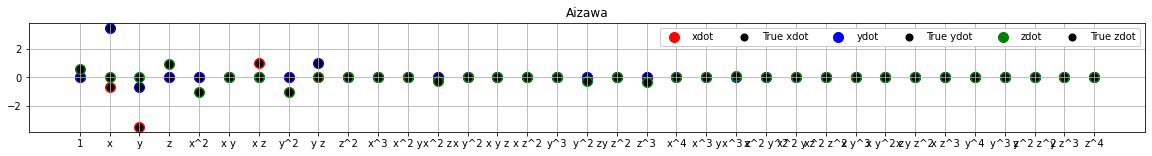

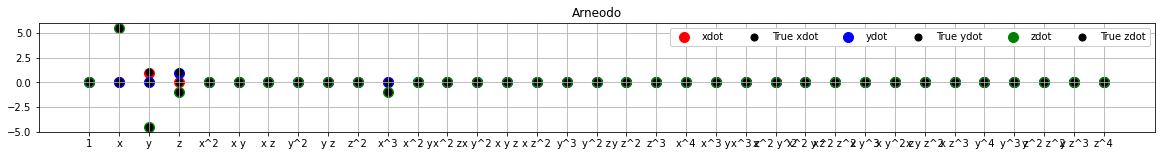

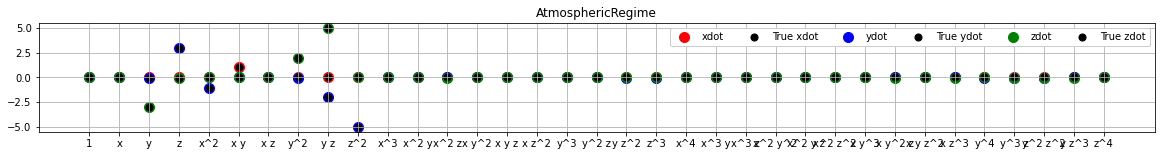

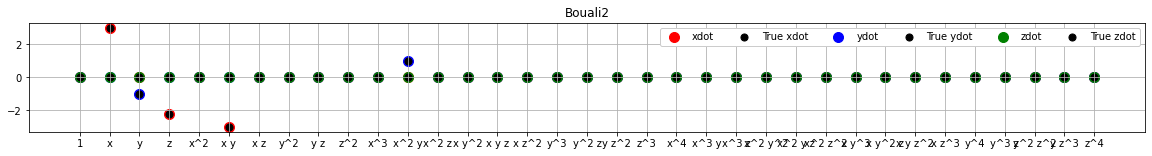

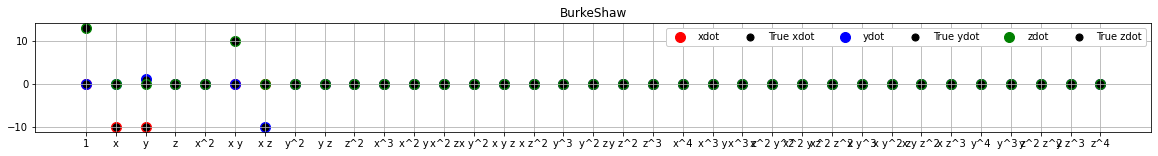

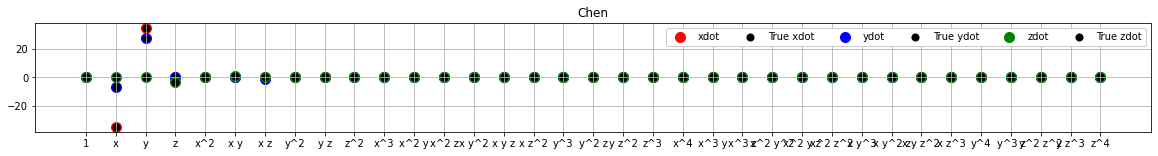

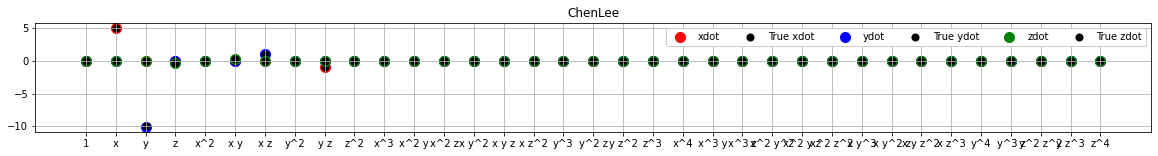

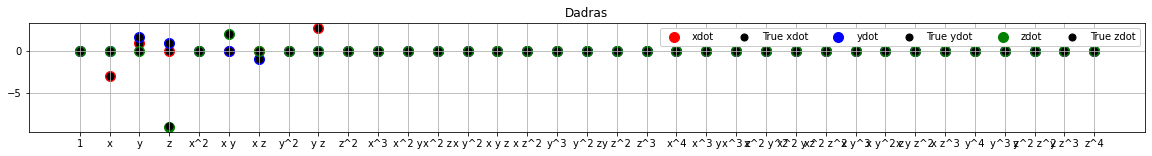

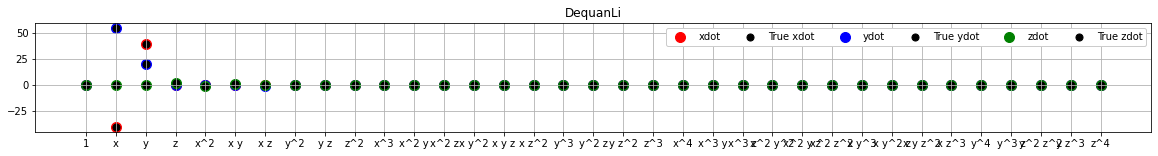

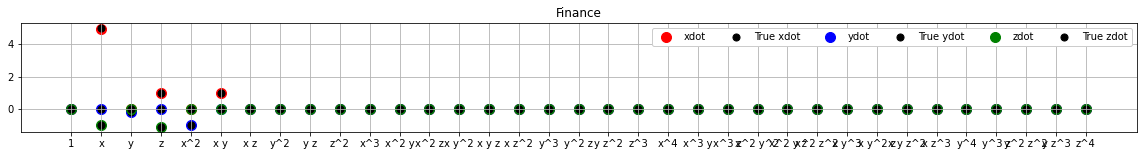

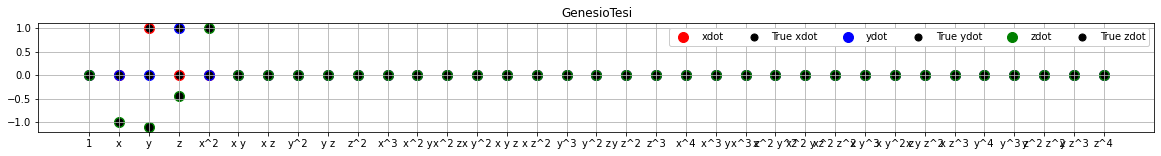

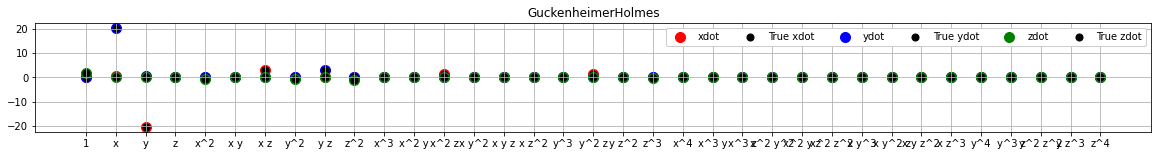

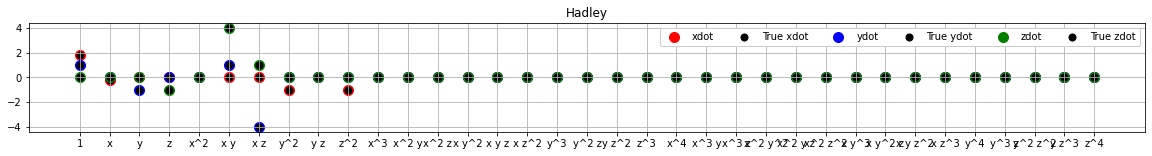

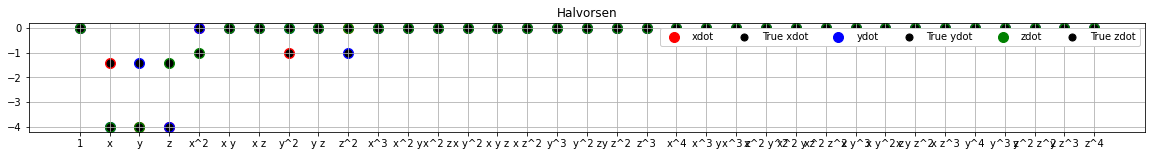

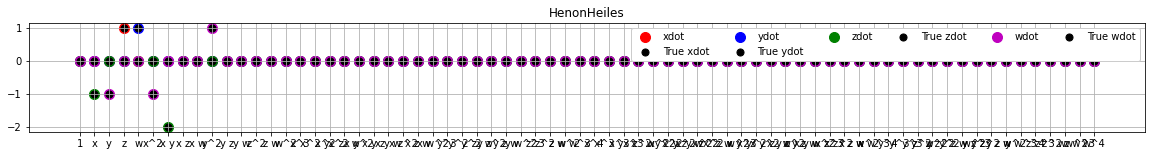

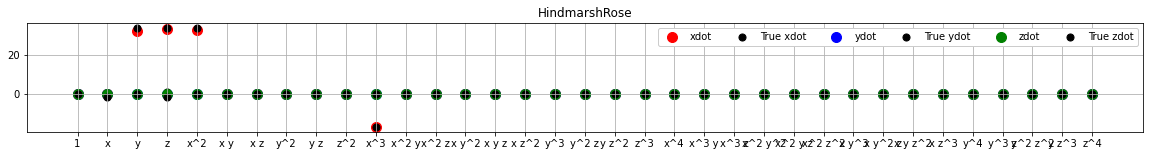

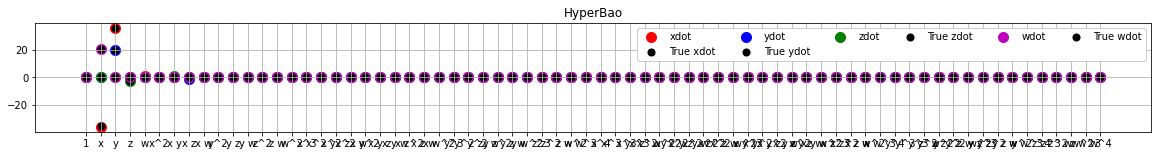

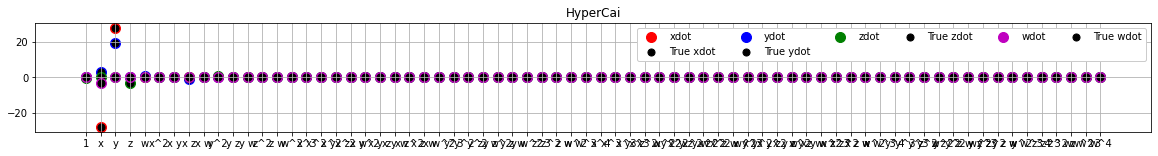

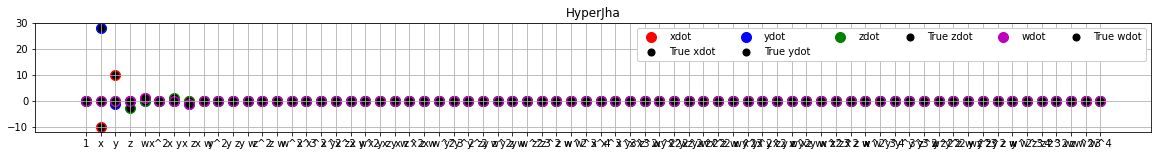

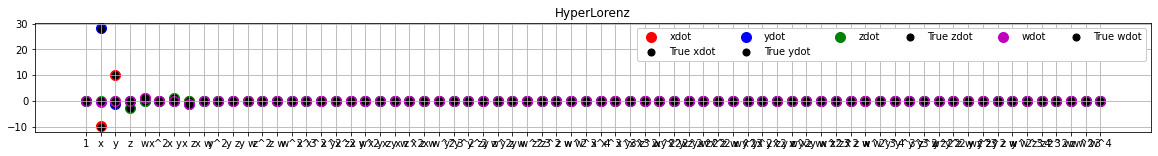

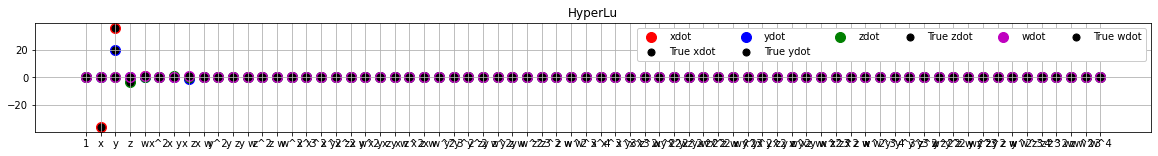

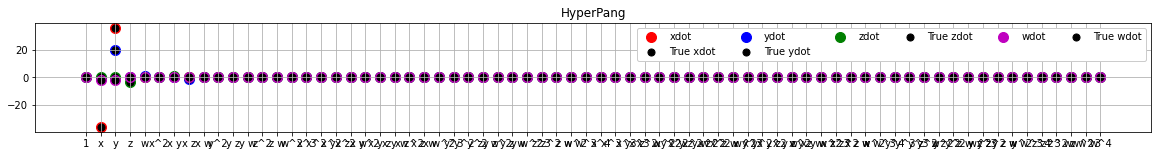

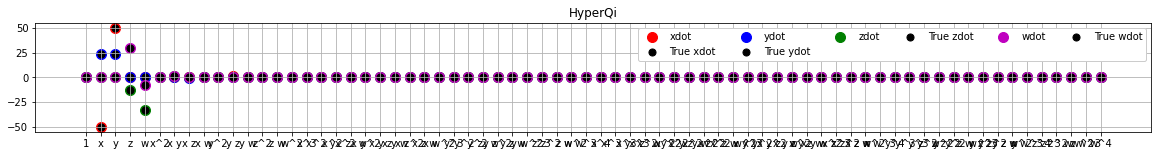

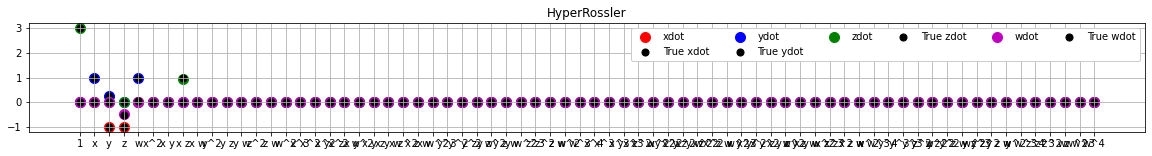

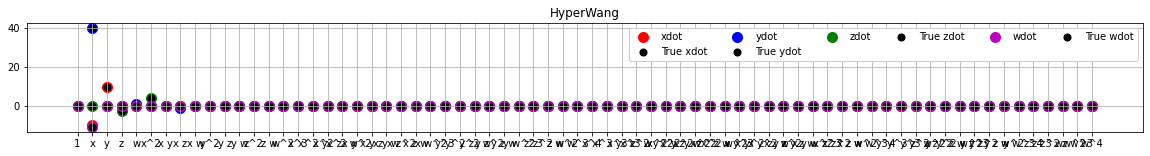

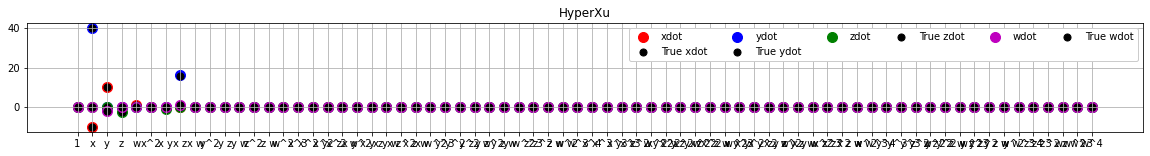

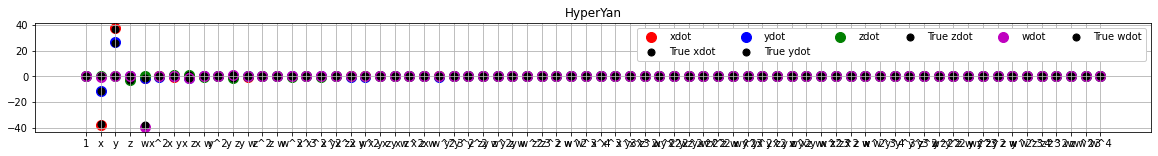

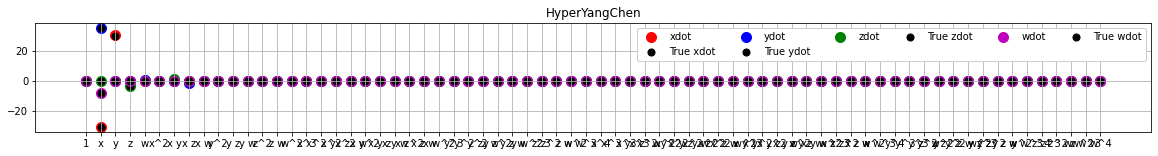

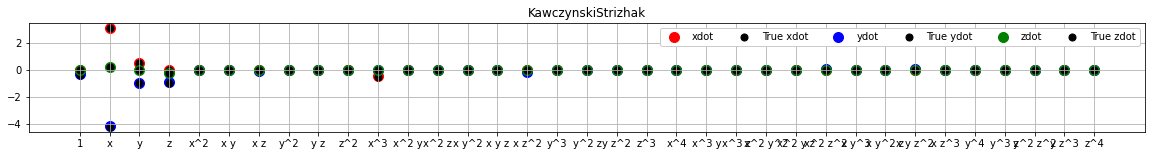

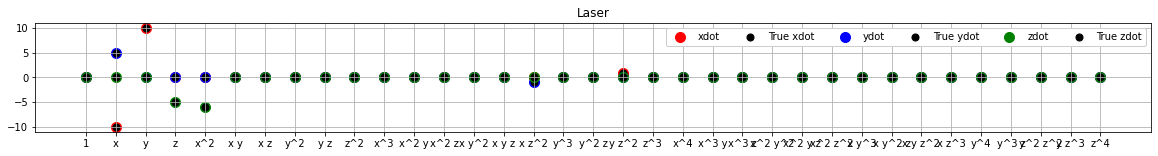

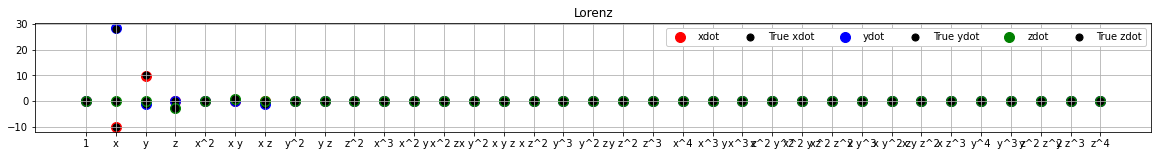

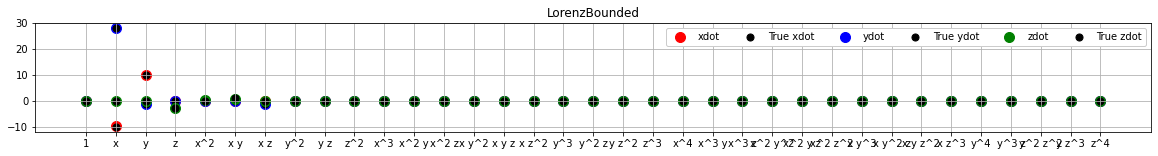

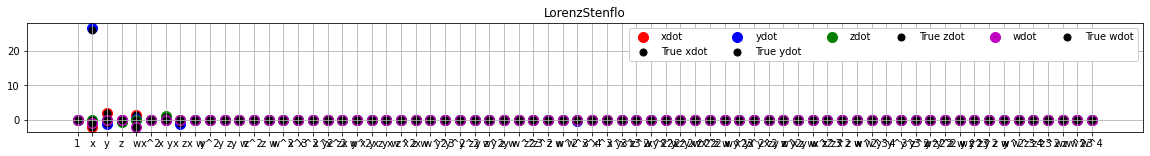

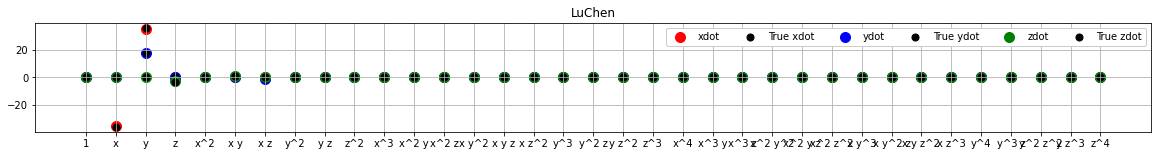

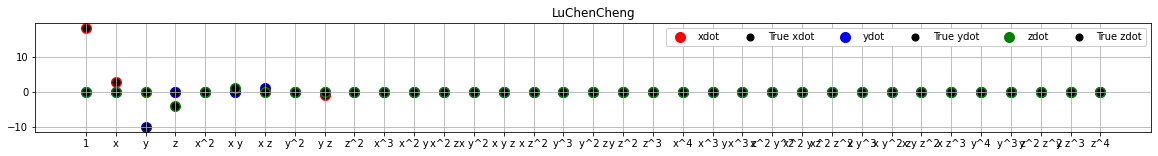

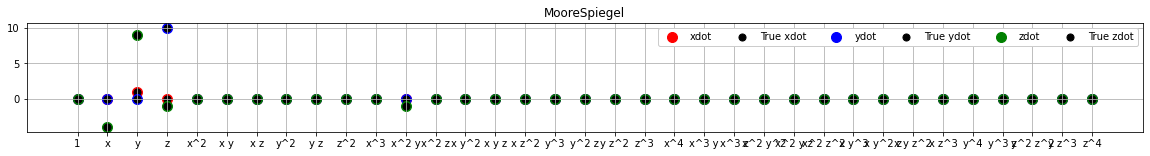

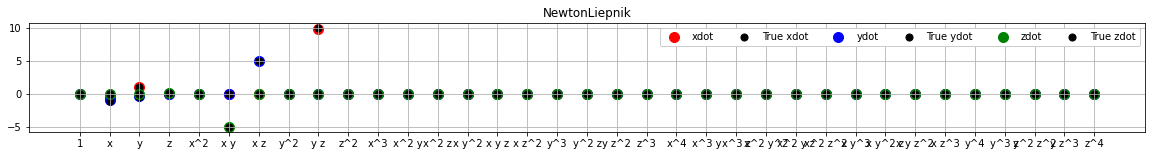

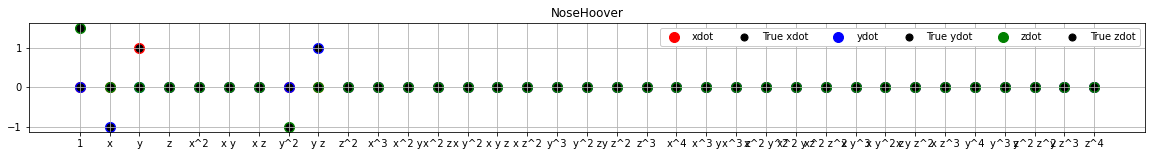

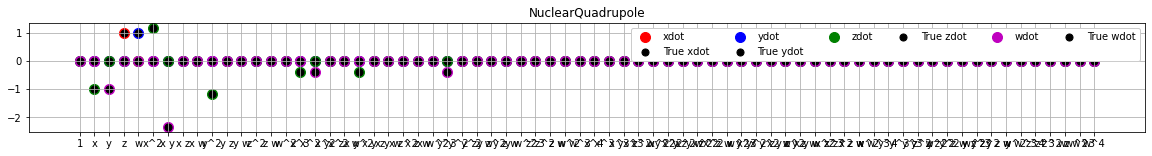

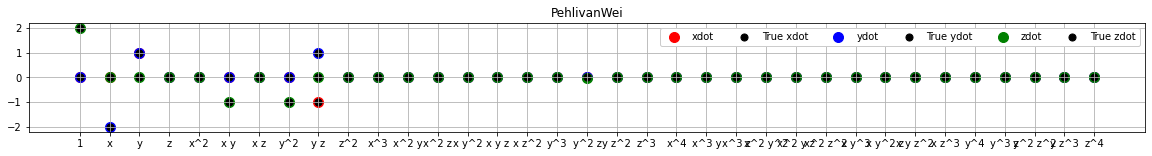

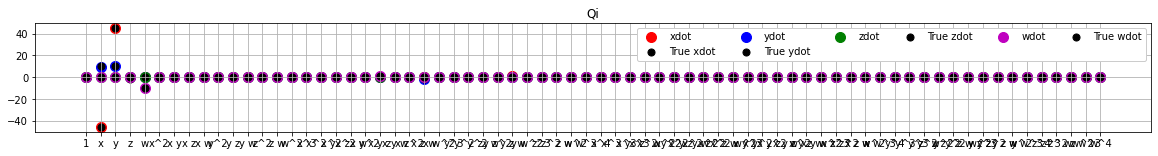

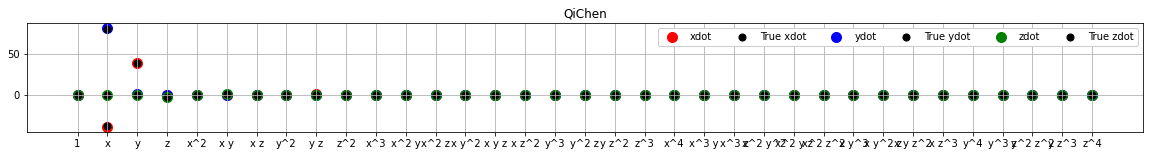

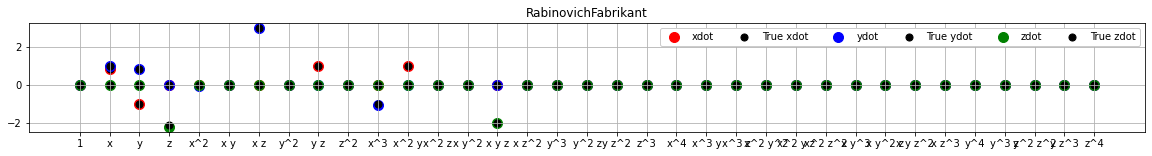

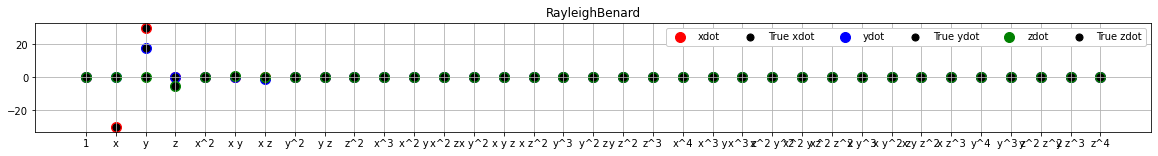

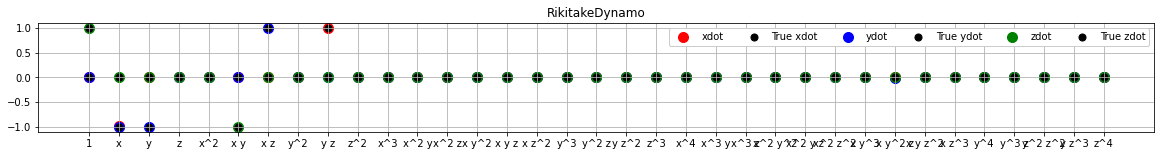

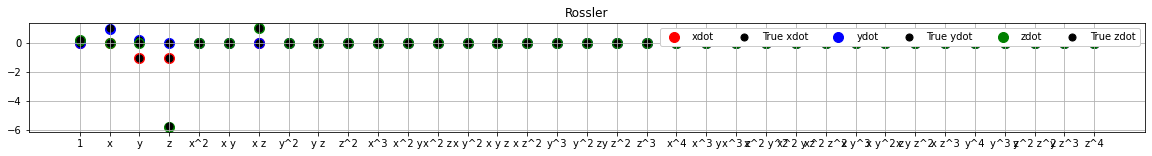

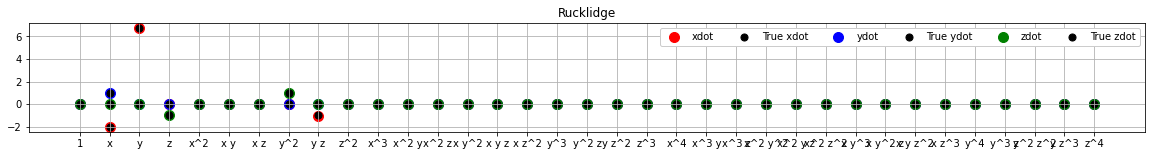

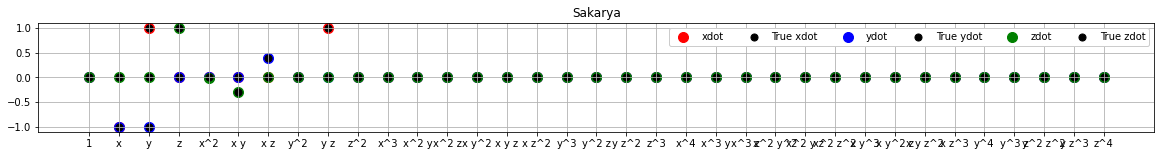

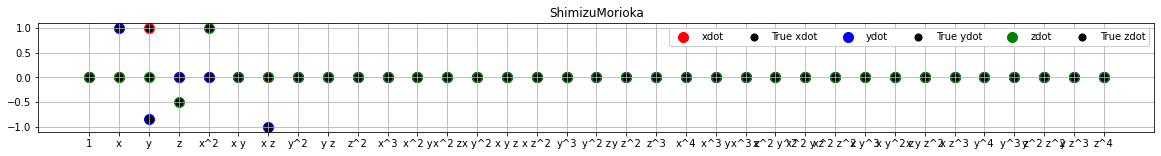

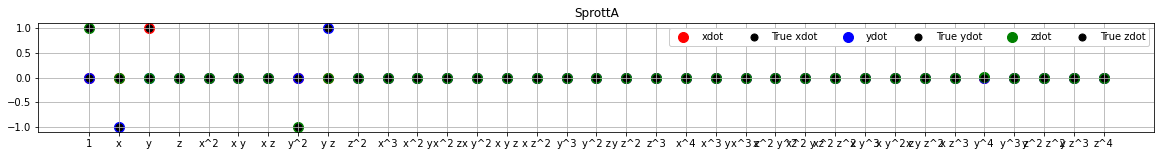

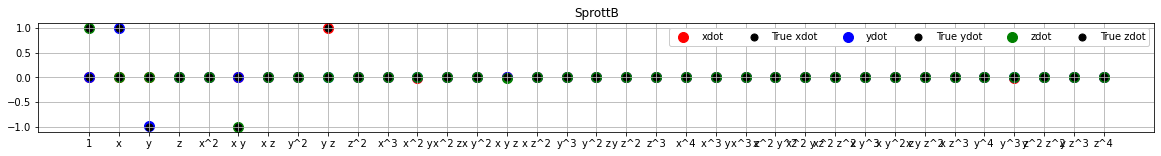

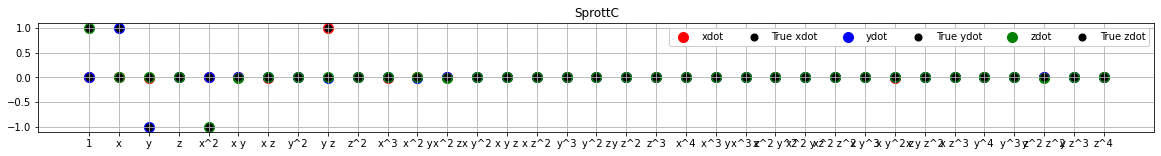

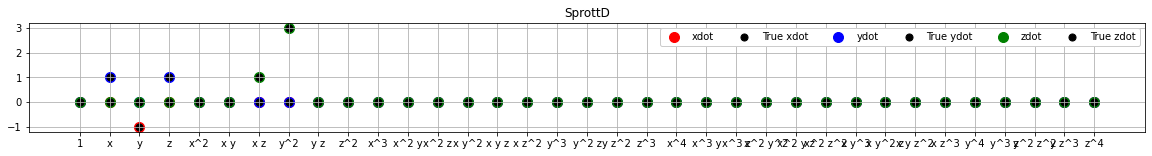

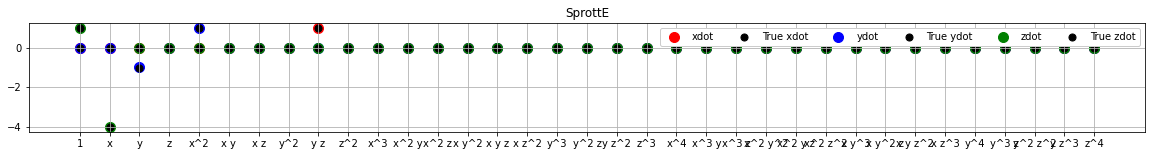

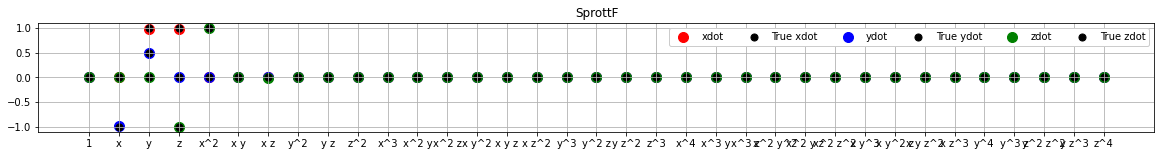

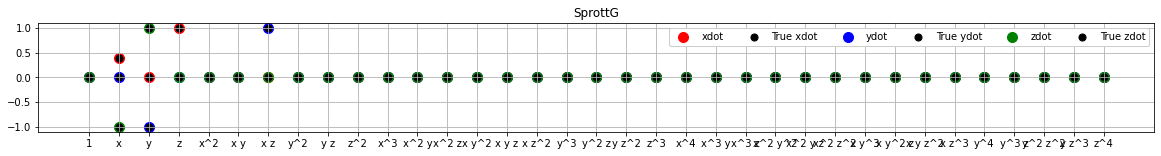

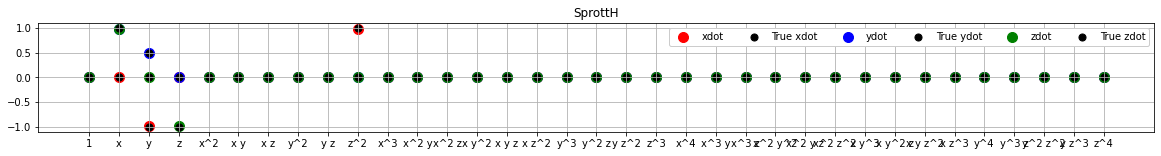

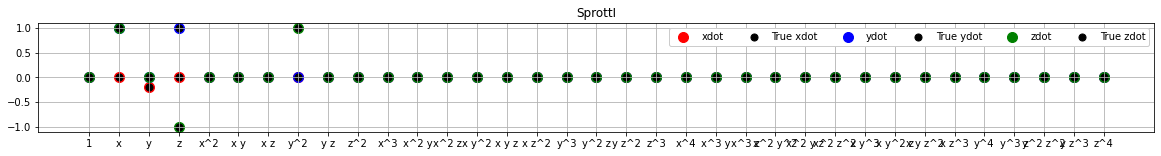

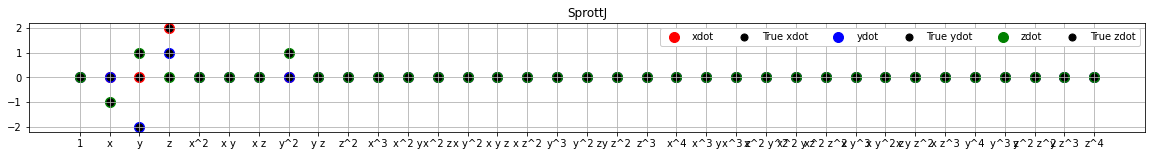

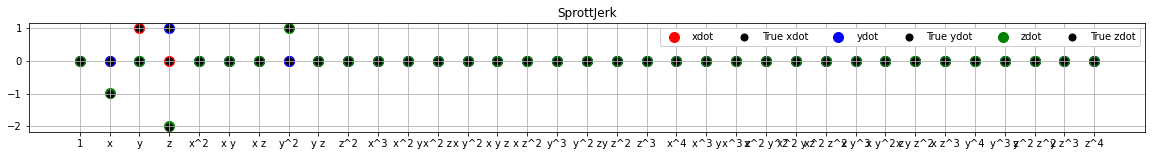

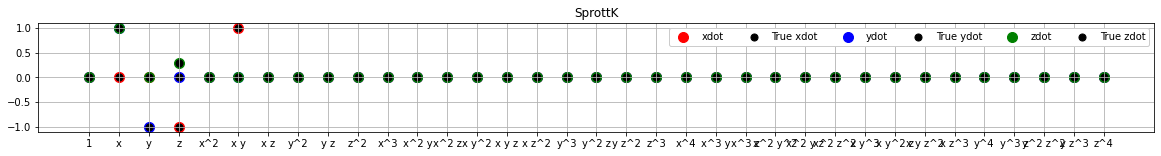

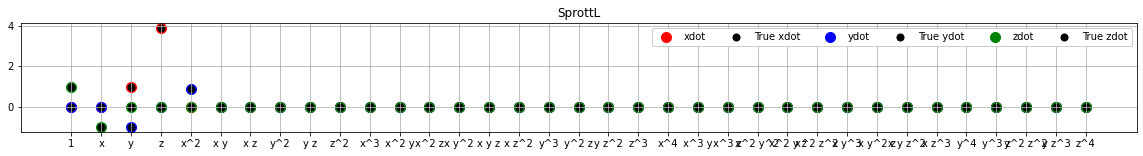

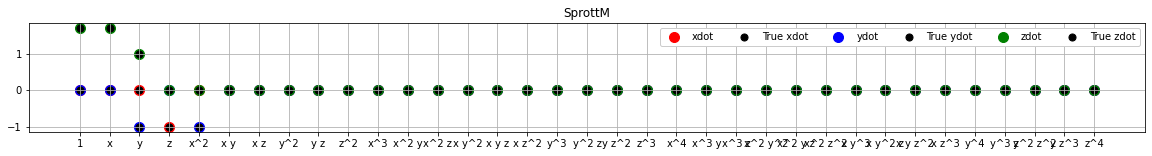

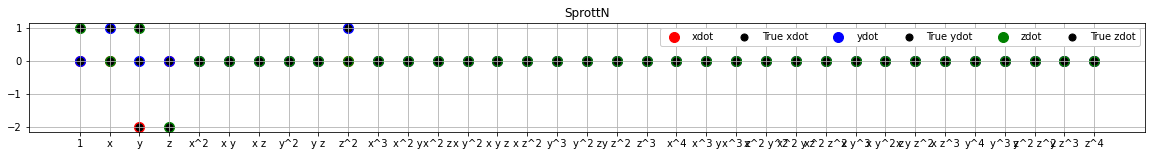

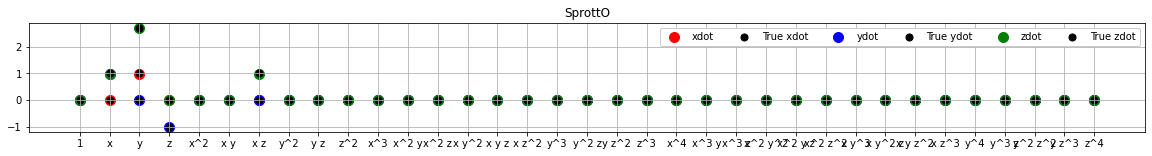

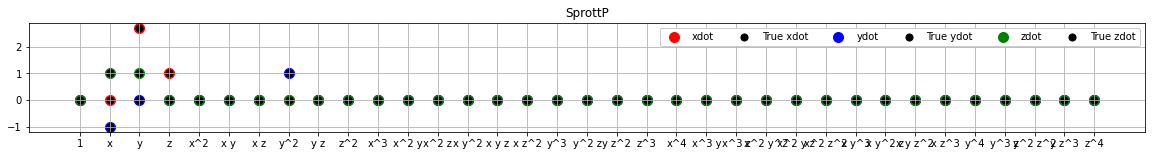

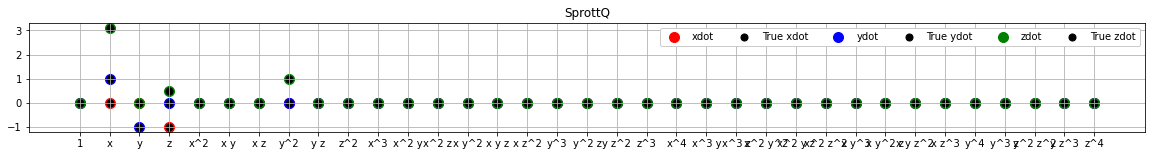

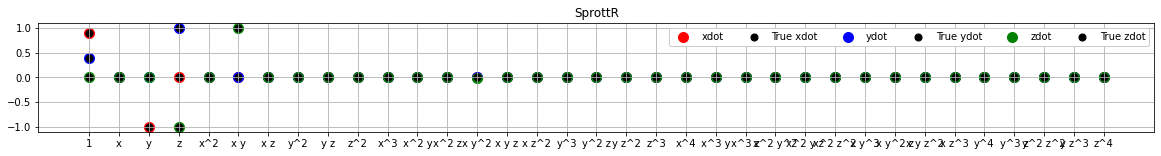

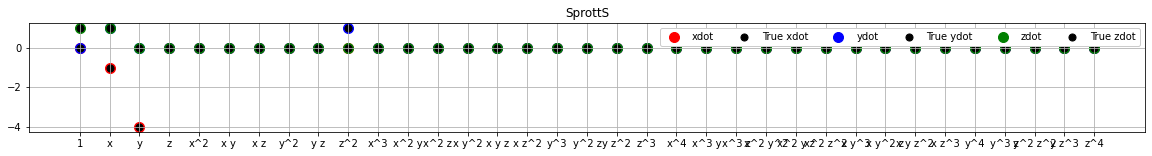

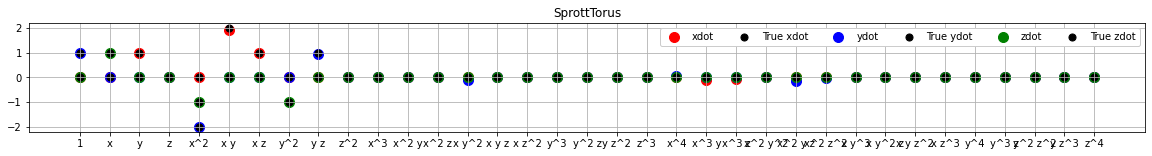

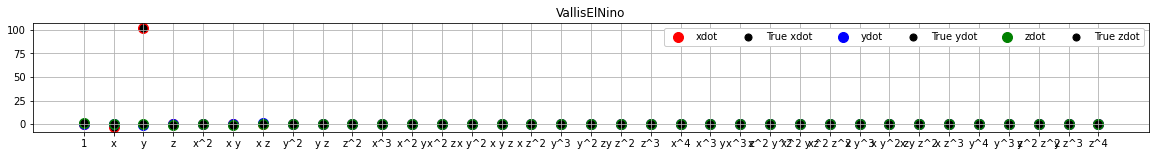

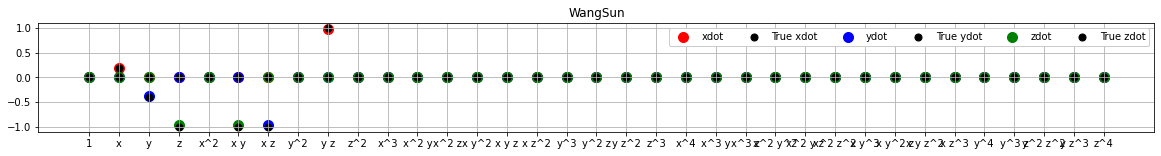

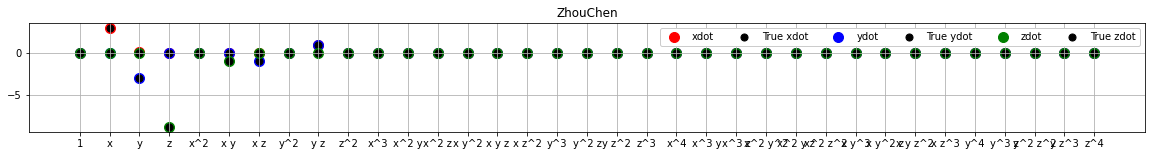

In [7]:
colors = ['r', 'b', 'g', 'm']
labels = ['xdot', 'ydot', 'zdot', 'wdot']

for i, system in enumerate(systems_list):
    x_train = all_sols_train[system]
    plt.figure(figsize=(20, 2))
    if dimension_list[i] == 3:
        feature_names = poly_library.fit(x_train).get_feature_names(['x', 'y', 'z'])
    else:
        feature_names = poly_library.fit(x_train).get_feature_names(['x', 'y', 'z', 'w'])
    for k in range(dimension_list[i]):
        # print(i, k, system, dimension_list[i])
        plt.grid(True)
        plt.scatter(feature_names, np.mean(np.array(predicted_coefficients[system])[:, k, :], 0), 
                        color=colors[k], label=labels[k], s=100)
        plt.scatter(feature_names, np.array(true_coefficients[i][k, :]), 
                        color='k', label='True ' + labels[k], s=50)
    if dimension_list[i] == 3:
        plt.legend(loc='upper right', framealpha=1.0, ncol=6)
    else:
        plt.legend(loc='upper right', framealpha=1.0, ncol=8)
    plt.title(system)
    #plt.yscale('symlog', linthreshy=1e-3)
    plt.legend(loc='upper right', framealpha=1.0, ncol=6)
    print(system)
    models[i].print()

0 SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4),
      feature_names=['x', 'y', 'z'],
      optimizer=STLSQ(alpha=1e-05, max_iter=100, normalize_columns=True,
                      ridge_kw={'tol': 1e-10}, threshold=1.3104630936003072)) Aizawa (5000,) (5000, 3) (5000, 3)
0 Aizawa 3
0.013228226102147106
1 SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4),
      feature_names=['x', 'y', 'z'],
      optimizer=STLSQ(alpha=1e-05, max_iter=100, normalize_columns=True,
                      ridge_kw={'tol': 1e-10}, threshold=0.36572619880088325)) Arneodo (5000,) (5000, 3) (5000, 3)
1 Arneodo 3
0.3497535844636129
2 SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4),
      feature_names=['x', 'y', 'z'],
      optimizer=STLSQ(alpha=1e-05, max_iter=100, normalize_columns=True,
                      ridge_kw={'tol': 1e-10}, threshold=0.01648446623609

167.98623276055173
26 SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4),
      feature_names=['x', 'y', 'z', 'w'],
      optimizer=STLSQ(alpha=1e-05, max_iter=100, normalize_columns=True,
                      ridge_kw={'tol': 1e-10}, threshold=48.45679957391787)) HyperYan (5000,) (5000, 4) (5000, 4)
26 HyperYan 4
397.09316946629684
27 SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4),
      feature_names=['x', 'y', 'z', 'w'],
      optimizer=STLSQ(alpha=1e-05, max_iter=100, normalize_columns=True,
                      ridge_kw={'tol': 1e-10}, threshold=373.2874782353799)) HyperYangChen (5000,) (5000, 4) (5000, 4)
27 HyperYangChen 4
283.01946928819194
28 SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4),
      feature_names=['x', 'y', 'z'],
      optimizer=STLSQ(alpha=1e-05, max_iter=100, normalize_columns=True,
                      ridge_

0.07088692260035302
50 SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4),
      feature_names=['x', 'y', 'z'],
      optimizer=STLSQ(alpha=1e-05, max_iter=100, normalize_columns=True,
                      ridge_kw={'tol': 1e-10}, threshold=0.6319748715279261)) SprottB (5000,) (5000, 3) (5000, 3)
50 SprottB 3
0.1612799864421306
51 SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4),
      feature_names=['x', 'y', 'z'],
      optimizer=STLSQ(alpha=1e-05, max_iter=100, normalize_columns=True,
                      ridge_kw={'tol': 1e-10}, threshold=0.021298666624708192)) SprottC (5000,) (5000, 3) (5000, 3)
51 SprottC 3
0.0032791903001762857
52 SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=4),
      feature_names=['x', 'y', 'z'],
      optimizer=STLSQ(alpha=1e-05, max_iter=100, normalize_columns=True,
                      ridge_kw={'tol': 1e-10

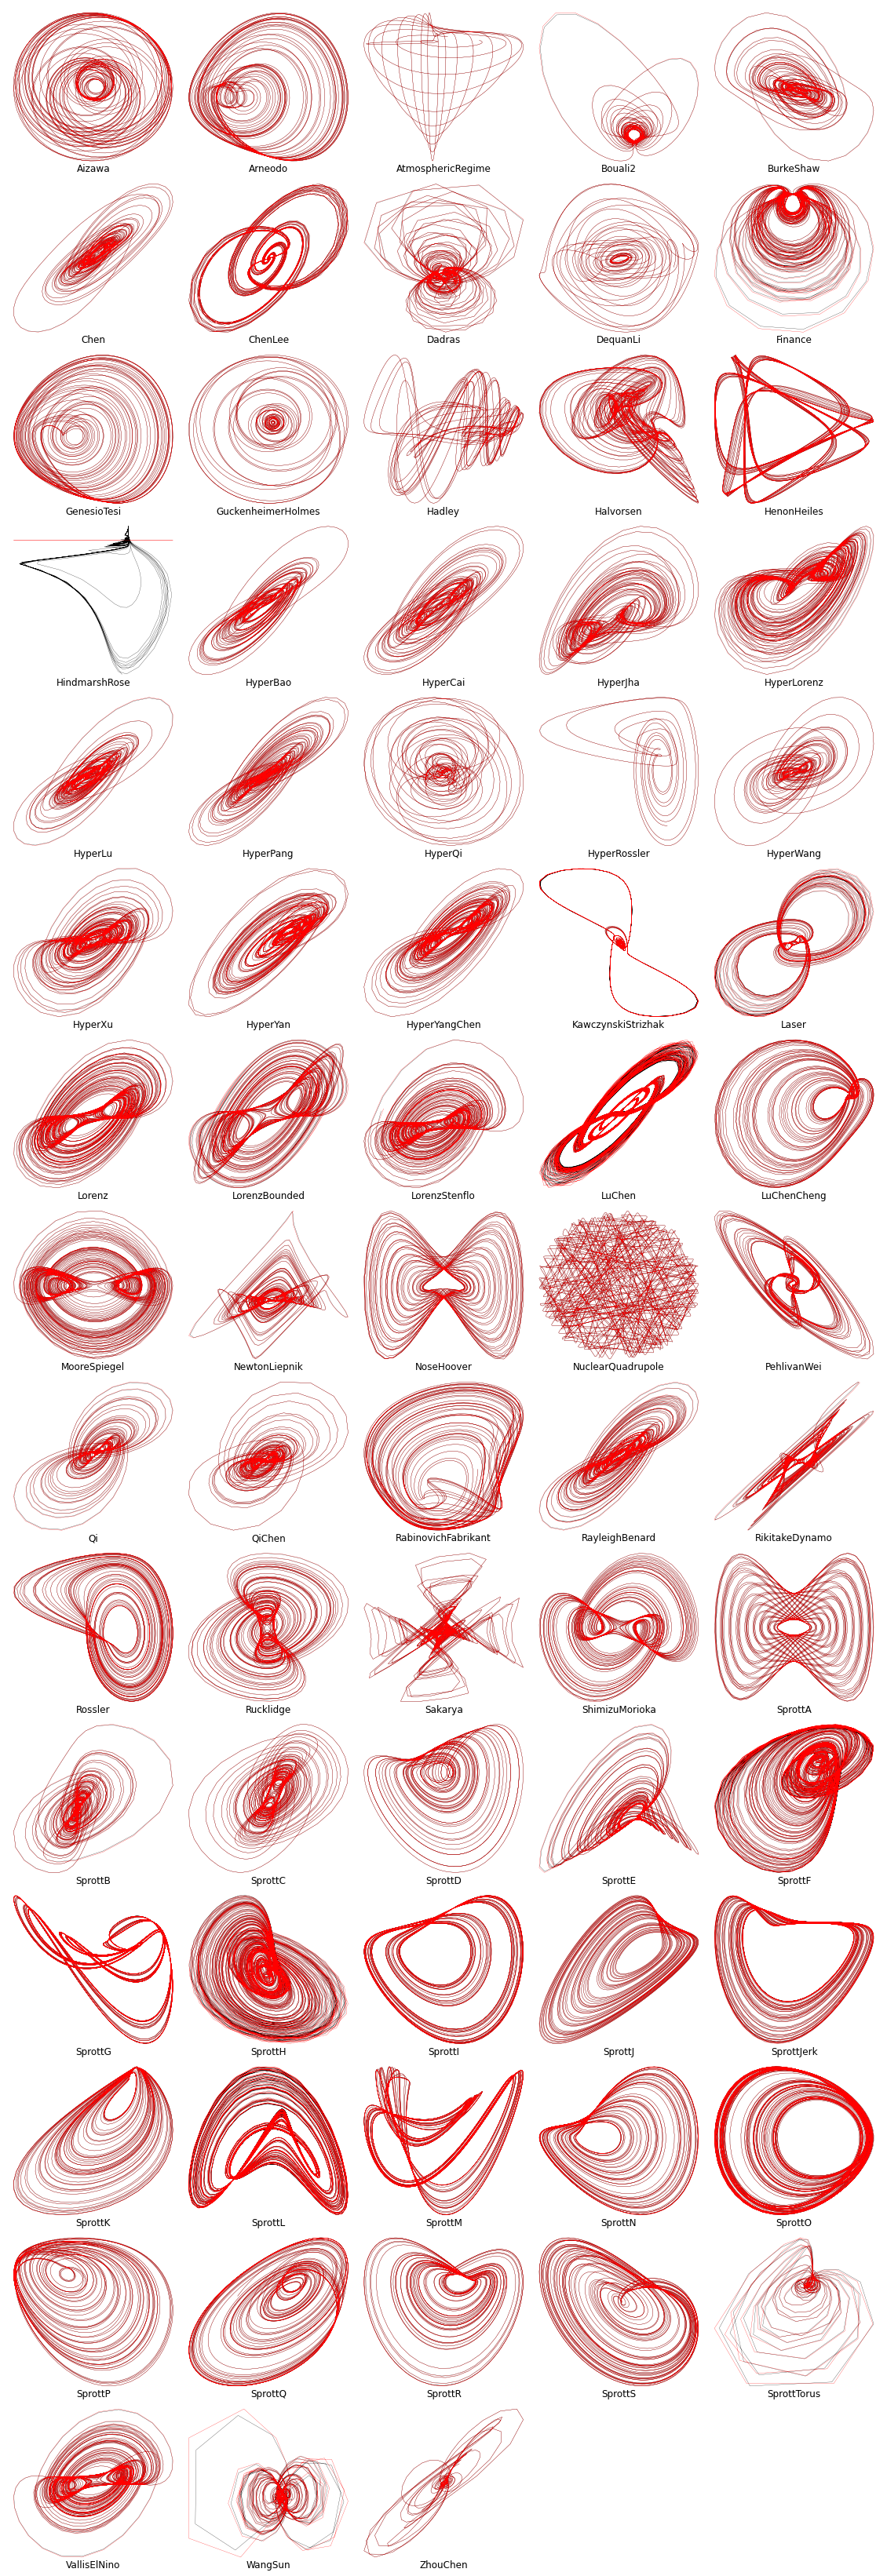

In [8]:
# Plot the training and testing trajectories for all the chaotic systems
num_cols = 5
num_rows = int(np.ceil(len(all_sols_train) / num_cols))
fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.05) 

for i, attractor_name in enumerate(all_sols_train):
    
    x_test = all_sols_test[attractor_name]
    t_test = all_t_test[attractor_name]
    print(i, models[i], attractor_name, t_test.shape, x_test.shape, all_sols_train[attractor_name].shape)
    print(i, attractor_name, dimension_list[i])


    x_dot_test = x_dot_tests[i]
    x_dot_test_pred = x_dot_test_preds[i]

    plt.subplot(gs[i])
    plt.plot(x_dot_test[:, 0], x_dot_test[:, 1], 'k', linewidth=0.25)
    plt.plot(x_dot_test_pred[:, 0], x_dot_test_pred[:, 1], 'r', linewidth=0.25)
    plt.title(attractor_name, y=-0.05)
    print(np.linalg.norm(x_dot_test - x_dot_test_pred, 2) ** 2)
    plt.gca().axis('off')
            
plt.savefig('polynomial_attractors_fits.jpg')
plt.savefig('polynomial_attractors_fits.pdf')